In [1]:
library(ggplot2)
library(data.table)
library(dplyr)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
COV=5

universal format: bed file, that has columns:
chr start end strand (if exists) coverage meth_ratio 

In [99]:
save_bed <- function(df, path){
    colnames(df) <- c("chr", "start", "end","strand", "coverage", "perc_meth_CpG")
    write.table(df, path, sep = "\t", row.names = F, quote = F)
}

In [125]:
save_bed_nostrand <- function(df, path){
    colnames(df) <- c("chr", "start", "end","coverage", "perc_meth_CpG")
    write.table(df, path, sep = "\t", row.names = F, quote = F)
}

## data type 1 - coverage & ratio (Gallus gallus all tissues except brain)

Data format: individual files with coverage and ratio values for each CpG. Tables are merged together based on the CpG location  
**Meth. ratio is used directly, CpGs are filtered to those, that have coverage more then 5**

In [1]:
files_list <- paste0("../../resources/WGBS_public/Gallus_gallus/", list.files("../../resources/WGBS_public/Gallus_gallus/", pattern = "*.tsv", recursive = T))

In [2]:
files_list

[1] "../../resources/WGBS_public/Gallus_gallus/breast_tissue/Breast_1_d34.tsv"       
 [2] "../../resources/WGBS_public/Gallus_gallus/breast_tissue/Breast_2_d34.tsv"       
 [3] "../../resources/WGBS_public/Gallus_gallus/breast_tissue/Breast_3_d34.tsv"       
 [4] "../../resources/WGBS_public/Gallus_gallus/ileum_tissue/Ile_1_d34.tsv"           
 [5] "../../resources/WGBS_public/Gallus_gallus/ileum_tissue/Ile_2_d34.tsv"           
 [6] "../../resources/WGBS_public/Gallus_gallus/ileum_tissue/Ile_3_d34.tsv"           
 [7] "../../resources/WGBS_public/Gallus_gallus/jejunum_tissue/Jejunum_1_d35_cont.tsv"
 [8] "../../resources/WGBS_public/Gallus_gallus/jejunum_tissue/Jejunum_2_d35_cont.tsv"
 [9] "../../resources/WGBS_public/Gallus_gallus/jejunum_tissue/Jejunum_3_d35_cont.tsv"
[10] "../../resources/WGBS_public/Gallus_gallus/spleen_tissue/Spleen_1_d34.tsv"       
[11] "../../resources/WGBS_public/Gallus_gallus/spleen_tissue/Spleen_2_d34.tsv"       
[12] "../../resources/WGBS_public/Gallus_gallus/spleen_tissue/Spleen_3_d34.tsv"

In [22]:
annot <- data.frame(path = files_list,
            path_unif= as.character(sapply(files_list, function(x) gsub(".tsv", ".bed",x))),
           tissue = as.character(sapply(files_list, function(x) gsub("_tissue", "", strsplit(x, "/")[[1]][6]))),
                    replica = as.character(sapply(files_list, function(x) strsplit(strsplit(x, "/")[[1]][7], "_")[[1]][2])), stringsAsFactors = FALSE)

In [19]:
write.table(annot, "../../resources/WGBS_public/Gallus_gallus/WGBS_annot.csv", row.names = FALSE, quote = FALSE, sep = ";")

In [32]:
mean_ratio = data.table()
for(i in c(1:NROW(annot))){
    print(annot$path[[i]])
    df <- fread(annot$path[[i]])
    print(NROW(df))
    ### saving the dataframe in the universal format (coverage threshold 0)
    save_bed(df[cov>0, c("chr", "start", "end", "cov", "ratio")], annot$path_unif[[i]])
    ## filtering by the COV threshold
    df_sub <- df[df$cov > COV, ]
    print(NROW(df_sub))
    mean_ratio <- rbind(mean_ratio, data.frame(path = as.character(annot$path[[i]]), mean_ratio = mean(df_sub$ratio)))
}

[1] "../../resources/WGBS_public/Gallus_gallus/breast_tissue/Breast_1_d34.tsv"
[1] 22806028
[1] 15373803
[1] "../../resources/WGBS_public/Gallus_gallus/breast_tissue/Breast_2_d34.tsv"
[1] 22806028
[1] 15951778
[1] "../../resources/WGBS_public/Gallus_gallus/breast_tissue/Breast_3_d34.tsv"
[1] 22806028
[1] 13805416
[1] "../../resources/WGBS_public/Gallus_gallus/ileum_tissue/Ile_1_d34.tsv"
[1] 22806028
[1] 16200511
[1] "../../resources/WGBS_public/Gallus_gallus/ileum_tissue/Ile_2_d34.tsv"
[1] 22806028
[1] 16858028
[1] "../../resources/WGBS_public/Gallus_gallus/ileum_tissue/Ile_3_d34.tsv"
[1] 22806028
[1] 19389494
[1] "../../resources/WGBS_public/Gallus_gallus/jejunum_tissue/Jejunum_1_d35_cont.tsv"
[1] 22806028
[1] 19059874
[1] "../../resources/WGBS_public/Gallus_gallus/jejunum_tissue/Jejunum_2_d35_cont.tsv"
[1] 22806028
[1] 19013611
[1] "../../resources/WGBS_public/Gallus_gallus/jejunum_tissue/Jejunum_3_d35_cont.tsv"
[1] 22806028
[1] 18457646
[1] "../../resources/WGBS_public/Gallus_gallus

In [49]:
mean_ratio <- left_join(mean_ratio, annot)

Joining, by = "path"



In [50]:
write.table(mean_ratio, "../validation/WGBS_public/Gallus_gallus_GSE146620.csv", sep = ";", quote = F, row.names = F)

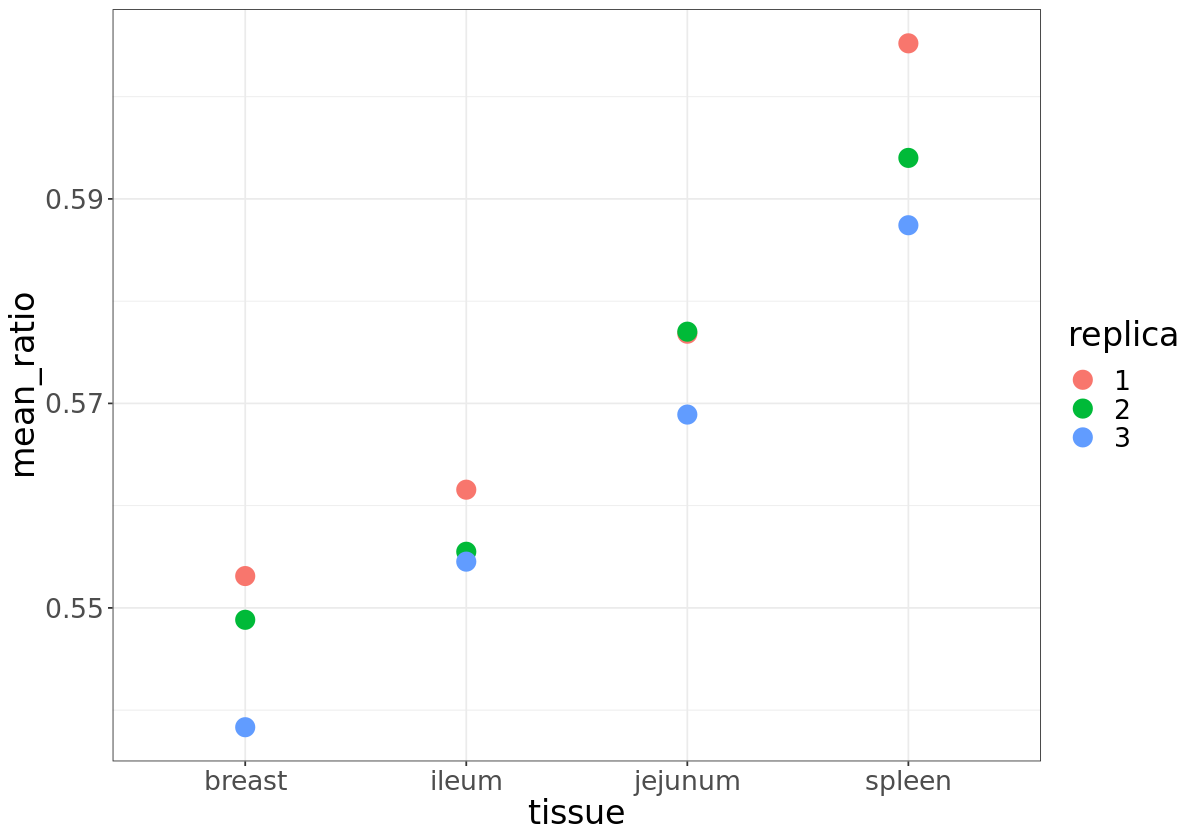

In [51]:
ggplot(mean_ratio, aes(x = tissue, y = mean_ratio, color = replica)) + geom_point(size = 5) + theme_bw() + theme(text = element_text(size = 20))

## data type 2 - CpG reports

Data format: Bismark cytosine report tab-delimited text files including chromosome, position, strand, methylated read count, unmethylated read count, cytosine context, and trinucleotide context.  **The methylation ratio is calculated as the mehylation count divided by the sum of the methylated and unmethylated counts (total) for each CpG, where total count is > 0.**

### Koala:

In [4]:
files_list <- paste0("../../resources/WGBS_public/Phascolarctos_cinereus/", list.files("../../resources/WGBS_public/Phascolarctos_cinereus/", pattern = "*CpG_report.txt", recursive = T))

Labeling the PC koala as replica 1, and the Ben - as replica 2

In [5]:
annot <- data.frame(path = files_list, 
            path_unif= as.character(sapply(files_list, function(x) gsub("_CpG_report.txt", ".bed",x))),
           tissue = as.character(sapply(files_list, function(x) strsplit(x, "/")[[1]][6])),
           replica = as.character(sapply(files_list, function(x) ifelse(length(grep("PC", x))==1, 1,2))), stringsAsFactors = FALSE)
head(annot)

,path,path_unif,tissue,replica
,<chr>,<chr>,<chr>,<chr>
1,../../resources/WGBS_public/Phascolarctos_cinereus/kidney/GSM4505502_WGM145_06_S3_kidney_PC_CpG_report.txt,../../resources/WGBS_public/Phascolarctos_cinereus/kidney/GSM4505502_WGM145_06_S3_kidney_PC.bed,kidney,1
2,../../resources/WGBS_public/Phascolarctos_cinereus/kidney/GSM4505503_WGM145_08_S4_kidney_Ben_CpG_report.txt,../../resources/WGBS_public/Phascolarctos_cinereus/kidney/GSM4505503_WGM145_08_S4_kidney_Ben.bed,kidney,2
3,../../resources/WGBS_public/Phascolarctos_cinereus/lung/GSM4505504_WGM145_09_S5_lung_PC_CpG_report.txt,../../resources/WGBS_public/Phascolarctos_cinereus/lung/GSM4505504_WGM145_09_S5_lung_PC.bed,lung,1
4,../../resources/WGBS_public/Phascolarctos_cinereus/lung/GSM4505505_WGM145_12_S6_lung_Ben_CpG_report.txt,../../resources/WGBS_public/Phascolarctos_cinereus/lung/GSM4505505_WGM145_12_S6_lung_Ben.bed,lung,2
5,../../resources/WGBS_public/Phascolarctos_cinereus/pancreas/GSM4505508_WGM145_19_S9_pancreas_PC_CpG_report.txt,../../resources/WGBS_public/Phascolarctos_cinereus/pancreas/GSM4505508_WGM145_19_S9_pancreas_PC.bed,pancreas,1
6,../../resources/WGBS_public/Phascolarctos_cinereus/pancreas/GSM4505509_WGM145_20_S10_pancreas_Ben_CpG_report.txt,../../resources/WGBS_public/Phascolarctos_cinereus/pancreas/GSM4505509_WGM145_20_S10_pancreas_Ben.bed,pancreas,2


In [6]:
write.table(annot, "../../resources/WGBS_public/Phascolarctos_cinereus/WGBS_annot.csv", row.names = FALSE, quote = FALSE, sep = ";")

In [7]:
mean_ratio = data.table()
for(i in c(1:NROW(annot))){
    print(annot$path[[i]])
    df <- fread(annot$path[[i]])
    print(NROW(df))
    colnames(df) <- c("chr", "position", "strand", "meth_count", "unmeth_count", "cytosine_context", "trinucleotide_context")
    df <- df[df$cytosine_context == "CG", ]
    df_f <- df %>% mutate(total_count = meth_count + unmeth_count) %>%
        filter(total_count > 0) %>%
        mutate(meth_ratio = meth_count/total_count, end = position + 1)
    save_bed(df_f[,c("chr", "position", "end", "strand", "total_count", "meth_ratio")], annot$path_unif[[i]])
    df_f <- df_f %>% filter(total_count > COV)
    print(NROW(df_f))
    mean_ratio <- rbind(mean_ratio, data.frame(path = as.character(annot$path[[i]]), mean_ratio = mean(df_f$meth_ratio, na.rm = T)))
}
mean_ratio <- left_join(mean_ratio, annot)

[1] "../../resources/WGBS_public/Phascolarctos_cinereus/pancreas/GSM4505509_WGM145_20_S10_pancreas_Ben_CpG_report.txt"
[1] 33523543
[1] 12816607
[1] "../../resources/WGBS_public/Phascolarctos_cinereus/Right_hemisphere_cerebral_lobe/GSM4505500_WGM145_01_S1_brain_PC_CpG_report.txt"
[1] 33523543
[1] 16872004
[1] "../../resources/WGBS_public/Phascolarctos_cinereus/Right_hemisphere_cerebral_lobe/GSM4505501_WGM145_04_S2_brain_Ben_CpG_report.txt"
[1] 33523543
[1] 17450493
[1] "../../resources/WGBS_public/Phascolarctos_cinereus/skeletal_muscle/GSM4505506_WGM145_14_S7_skeletal_muscle_PC_CpG_report.txt"
[1] 33523543
[1] 13330905
[1] "../../resources/WGBS_public/Phascolarctos_cinereus/skeletal_muscle/GSM4505507_WGM145_16_S8_skeletal_muscle_Ben_CpG_report.txt"
[1] 33523543
[1] 13642676


Joining, by = "path"



In [5]:
write.table(mean_ratio, "../validation/WGBS_public/Phascolarctos_cinereus_GSE149600.csv", sep = ";", quote = F, row.names = F)

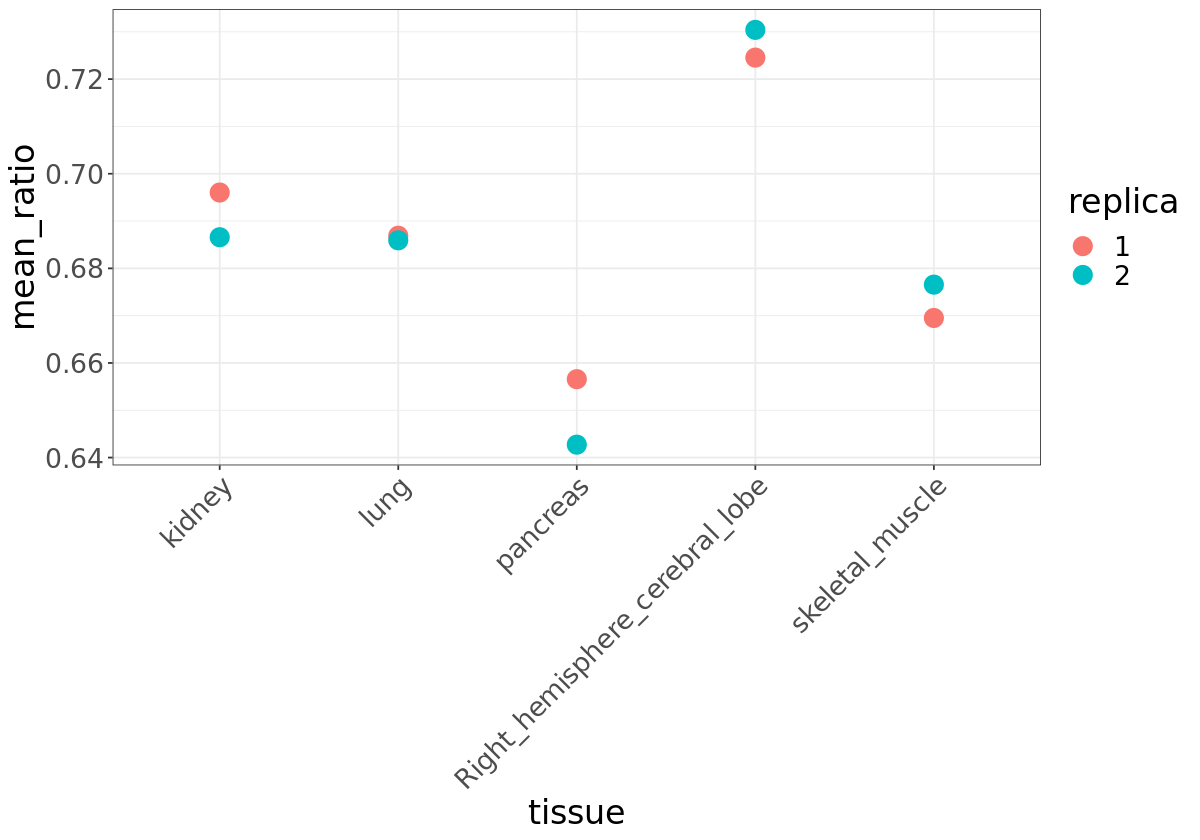

In [6]:
options(repr.plot.width = 10)
ggplot(mean_ratio, aes(x = tissue, y = mean_ratio, color = replica)) + geom_point(size = 5) + 
                            theme_bw() + theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1))

### cow

In [22]:
files_list <- paste0("../../resources/WGBS_public/Bos_taurus/", list.files("../../resources/WGBS_public/Bos_taurus/", pattern = "*CpG_report.txt", recursive = T))

Extracting tissue and replica id

In [23]:
annot <- data.frame(path = files_list, 
            path_unif= as.character(sapply(files_list, function(x) gsub(".CpG_report.txt", ".bed",x))),
           tissue = as.character(sapply(files_list, function(x) strsplit(x, "/")[[1]][6])),
           replica = as.character(sapply(files_list, function(x) strsplit(x, "_")[[1]][5] )), stringsAsFactors = FALSE)
head(annot)

,path,path_unif,tissue,replica
,<chr>,<chr>,<chr>,<chr>
1,../../resources/WGBS_public/Bos_taurus/Adipose/GSM4238269_Adipose_3842_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt,../../resources/WGBS_public/Bos_taurus/Adipose/GSM4238269_Adipose_3842_1.fq.gz_bismark_bt2_pe.deduplicated.bed,Adipose,3842
2,../../resources/WGBS_public/Bos_taurus/Adipose/GSM4238270_Adipose_3886_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt,../../resources/WGBS_public/Bos_taurus/Adipose/GSM4238270_Adipose_3886_1.fq.gz_bismark_bt2_pe.deduplicated.bed,Adipose,3886
3,../../resources/WGBS_public/Bos_taurus/Adipose/GSM4416578_Adipose_DtFat_1_val_1_bismark_bt2_pe.deduplicated.CpG_report.txt.CpG_report.txt,../../resources/WGBS_public/Bos_taurus/Adipose/GSM4416578_Adipose_DtFat_1_val_1_bismark_bt2_pe.deduplicated.bed.bed,Adipose,DtFat
4,../../resources/WGBS_public/Bos_taurus/Blood/GSM4238271_Blood_4091_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt,../../resources/WGBS_public/Bos_taurus/Blood/GSM4238271_Blood_4091_1.fq.gz_bismark_bt2_pe.deduplicated.bed,Blood,4091
5,../../resources/WGBS_public/Bos_taurus/Blood/GSM4238272_Blood_4254_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt,../../resources/WGBS_public/Bos_taurus/Blood/GSM4238272_Blood_4254_1.fq.gz_bismark_bt2_pe.deduplicated.bed,Blood,4254
6,../../resources/WGBS_public/Bos_taurus/Heart/GSM4238273_Heart_3842_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt,../../resources/WGBS_public/Bos_taurus/Heart/GSM4238273_Heart_3842_1.fq.gz_bismark_bt2_pe.deduplicated.bed,Heart,3842


In [24]:
annot$genomeid <- "Bos_taurus"

In [25]:
write.table(annot, "../../resources/WGBS_public/Bos_taurus/WGBS_annot.csv", row.names = FALSE, quote = FALSE, sep = ";")

In [26]:
mean_ratio = data.table()
for(i in c(1:NROW(annot))){
    print(annot$path[[i]])
    df <- fread(annot$path[[i]])
    print(NROW(df))
    colnames(df) <- c("chr", "position", "strand", "meth_count", "unmeth_count", "cytosine_context", "trinucleotide_context")
    df <- df[df$cytosine_context == "CG", ]
    df_f <- df %>% mutate(total_count = meth_count + unmeth_count) %>%
        filter(total_count > 0) %>% ## theoretically can be filtered by 5
        mutate(meth_ratio = meth_count/total_count, end = position + 1)
    save_bed(df_f[,c("chr", "position", "end", "strand", "total_count", "meth_ratio")], annot$path_unif[[i]])
    df_f <- df_f %>% filter(total_count > COV)
    print(NROW(df_f))
    mean_ratio <- rbind(mean_ratio, data.frame(path = as.character(annot$path[[i]]), mean_ratio = mean(df_f$meth_ratio, na.rm = T)))
}
mean_ratio <- left_join(mean_ratio, annot)

[1] "../../resources/WGBS_public/Bos_taurus/Adipose/GSM4238269_Adipose_3842_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt"
[1] 58987503
[1] 13946480
[1] "../../resources/WGBS_public/Bos_taurus/Adipose/GSM4238270_Adipose_3886_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt"
[1] 58987503
[1] 14970434
[1] "../../resources/WGBS_public/Bos_taurus/Adipose/GSM4416578_Adipose_DtFat_1_val_1_bismark_bt2_pe.deduplicated.CpG_report.txt.CpG_report.txt"
[1] 58987435
[1] 9807085
[1] "../../resources/WGBS_public/Bos_taurus/Blood/GSM4238271_Blood_4091_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt"
[1] 58987503
[1] 11604945
[1] "../../resources/WGBS_public/Bos_taurus/Blood/GSM4238272_Blood_4254_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt"
[1] 58987503
[1] 21414617
[1] "../../resources/WGBS_public/Bos_taurus/Heart/GSM4238273_Heart_3842_1.fq.gz_bismark_bt2_pe.deduplicated.CpG_report.txt"
[1] 58987503
[1] 9718188
[1] "../../resources/WGBS_public/Bos_taurus/Heart/GSM4416579_Heart_DtHeart

Joining, by = "path"



In [27]:
mean_ratio <- left_join(mean_ratio[, c(1,2)], annot)

Joining, by = "path"



In [28]:
write.table(mean_ratio, "../validation/WGBS_public/Bos_taurus_GSE147087.csv", sep = ";", quote = F, row.names = F)

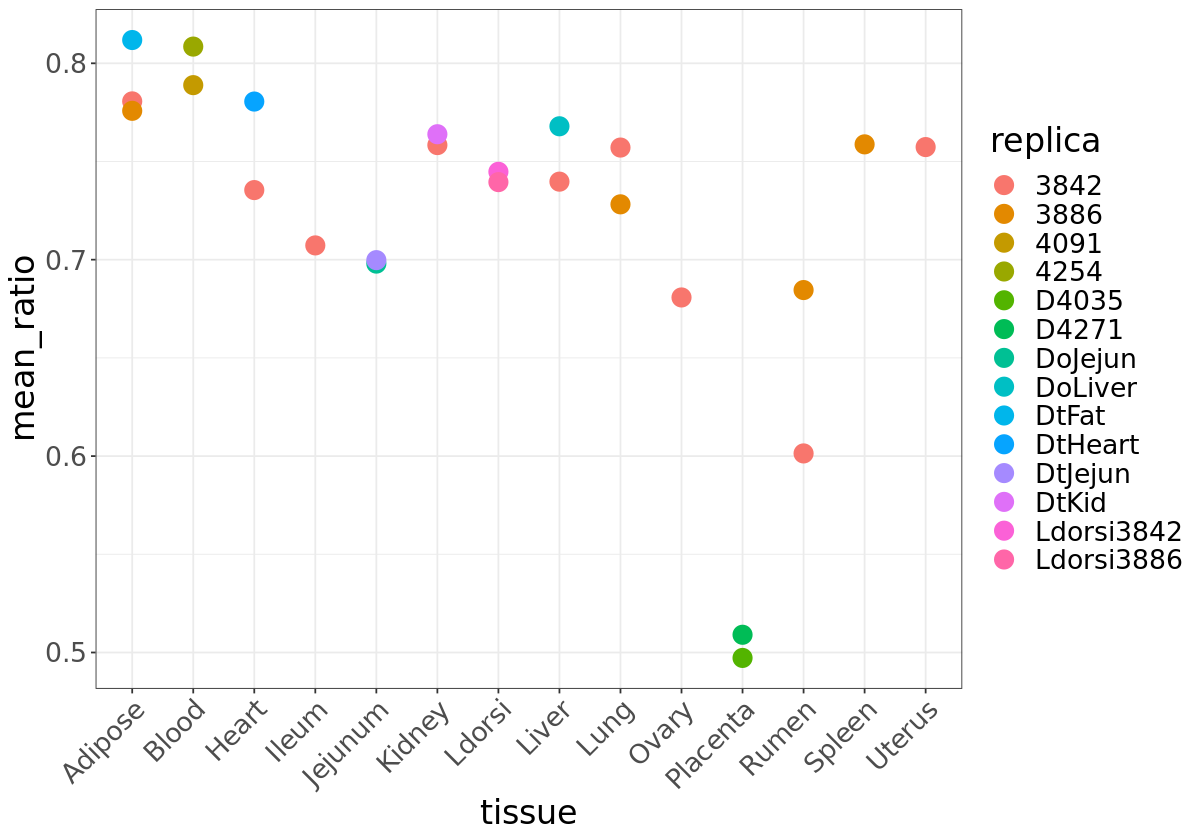

In [29]:
options(repr.plot.width = 10)
ggplot(mean_ratio, aes(x = tissue, y = mean_ratio, color = replica)) + geom_point(size = 5) + 
                            theme_bw() + theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1))

## Data type 3 - CpG calls
### mouse (only)

In [1]:
files_list <- paste0("../../resources/WGBS_public/Mus_musculus/", list.files("../../resources/WGBS_public/Mus_musculus/", pattern = "*CpG.calls.txt", recursive = T))

In [4]:
annot <- data.frame(path = files_list, 
             path_unif= as.character(sapply(files_list, function(x) gsub(".CpG.calls.txt", ".bed",x))),
           tissue = as.character(sapply(files_list, function(x) gsub("mouse_", "", strsplit(x, "/")[[1]][6]))),
                    replica = 1, stringsAsFactors = FALSE)

In [5]:
head(annot)

,path,path_unif,tissue,replica
,<chr>,<chr>,<chr>,<dbl>
1,../../resources/WGBS_public/Mus_musculus/mouse_bone_marrow/GSM1051150_bone_marrow.CpG.calls.txt,../../resources/WGBS_public/Mus_musculus/mouse_bone_marrow/GSM1051150_bone_marrow.bed,bone_marrow,1
2,../../resources/WGBS_public/Mus_musculus/mouse_cerebellum/GSM1051151_cerebellum.CpG.calls.txt,../../resources/WGBS_public/Mus_musculus/mouse_cerebellum/GSM1051151_cerebellum.bed,cerebellum,1
3,../../resources/WGBS_public/Mus_musculus/mouse_colon/GSM1051152_colon.CpG.calls.txt,../../resources/WGBS_public/Mus_musculus/mouse_colon/GSM1051152_colon.bed,colon,1
4,../../resources/WGBS_public/Mus_musculus/mouse_cortex/GSM1051153_cortex.CpG.calls.txt,../../resources/WGBS_public/Mus_musculus/mouse_cortex/GSM1051153_cortex.bed,cortex,1
5,../../resources/WGBS_public/Mus_musculus/mouse_heart/GSM1051154_heart.CpG.calls.txt,../../resources/WGBS_public/Mus_musculus/mouse_heart/GSM1051154_heart.bed,heart,1
6,../../resources/WGBS_public/Mus_musculus/mouse_intestine/GSM1051155_intestine.CpG.calls.txt,../../resources/WGBS_public/Mus_musculus/mouse_intestine/GSM1051155_intestine.bed,intestine,1


In [6]:
write.table(annot, "../../resources/WGBS_public/Mus_musculus/WGBS_annot.csv", row.names = FALSE, quote = FALSE, sep = ";")

In [11]:
df <- fread(annot$path[[1]])

In [12]:
head(df)

chromosome,CpG location left,CpG location right,#methylated CpG,#CpG sequenced,%mCG
<chr>,<int>,<int>,<int>,<int>,<dbl>
chr1,3000574,3000575,13,16,81.25
chr1,3000901,3000902,2,2,100.00
chr1,3002177,3002178,8,9,88.89
chr1,3002338,3002339,5,7,71.43
chr1,3002386,3002387,5,10,50.00
chr1,3002599,3002600,5,14,35.71


In [16]:
mean_ratio = data.table()
for(i in c(1:NROW(annot))){
    print(annot$path[[i]])
    df <- fread(as.character(annot$path[[i]]))

    print(NROW(df))
    colnames(df)[4] <- "CpG_meth"
    colnames(df)[5] <- "CpG_seq"
    colnames(df)[6] <- "CpG_meth_prc"
    df <- df[CpG_seq > 0]
    save_bed_nostrand(df[,c("chromosome", "CpG location left", "CpG location right", "CpG_seq", "CpG_meth_prc")], annot$path_unif[[i]])
    
    df_f <- df[CpG_seq > 5]
    
    print(NROW(df_f))
    
    mean_ratio <- rbind(mean_ratio, data.frame(path = as.character(annot$path[[i]]), mean_ratio = mean(df_f$CpG_meth_prc, na.rm = T)/100))
}
mean_ratio <- left_join(mean_ratio, annot)

[1] "../../resources/WGBS_public/Mus_musculus/mouse_bone_marrow/GSM1051150_bone_marrow.CpG.calls.txt"
[1] 16340104
[1] 13527880
[1] "../../resources/WGBS_public/Mus_musculus/mouse_cerebellum/GSM1051151_cerebellum.CpG.calls.txt"
[1] 16421937
[1] 14845151
[1] "../../resources/WGBS_public/Mus_musculus/mouse_colon/GSM1051152_colon.CpG.calls.txt"
[1] 15688707
[1] 13549631
[1] "../../resources/WGBS_public/Mus_musculus/mouse_cortex/GSM1051153_cortex.CpG.calls.txt"
[1] 18193457
[1] 17123077
[1] "../../resources/WGBS_public/Mus_musculus/mouse_heart/GSM1051154_heart.CpG.calls.txt"
[1] 18322700
[1] 15076675
[1] "../../resources/WGBS_public/Mus_musculus/mouse_intestine/GSM1051155_intestine.CpG.calls.txt"
[1] 16932452
[1] 15041450
[1] "../../resources/WGBS_public/Mus_musculus/mouse_kidney/GSM1051156_kidney.CpG.calls.txt"
[1] 16066447
[1] 12370615
[1] "../../resources/WGBS_public/Mus_musculus/mouse_liver/GSM1051157_liver.CpG.calls.txt"
[1] 16791805
[1] 10484432
[1] "../../resources/WGBS_public/Mus_m

Joining, by = "path"



In [33]:
write.table(mean_ratio, "../validation/WGBS_public/Mus_musculus_GSE42836.csv", sep = ";", quote = F, row.names = F)

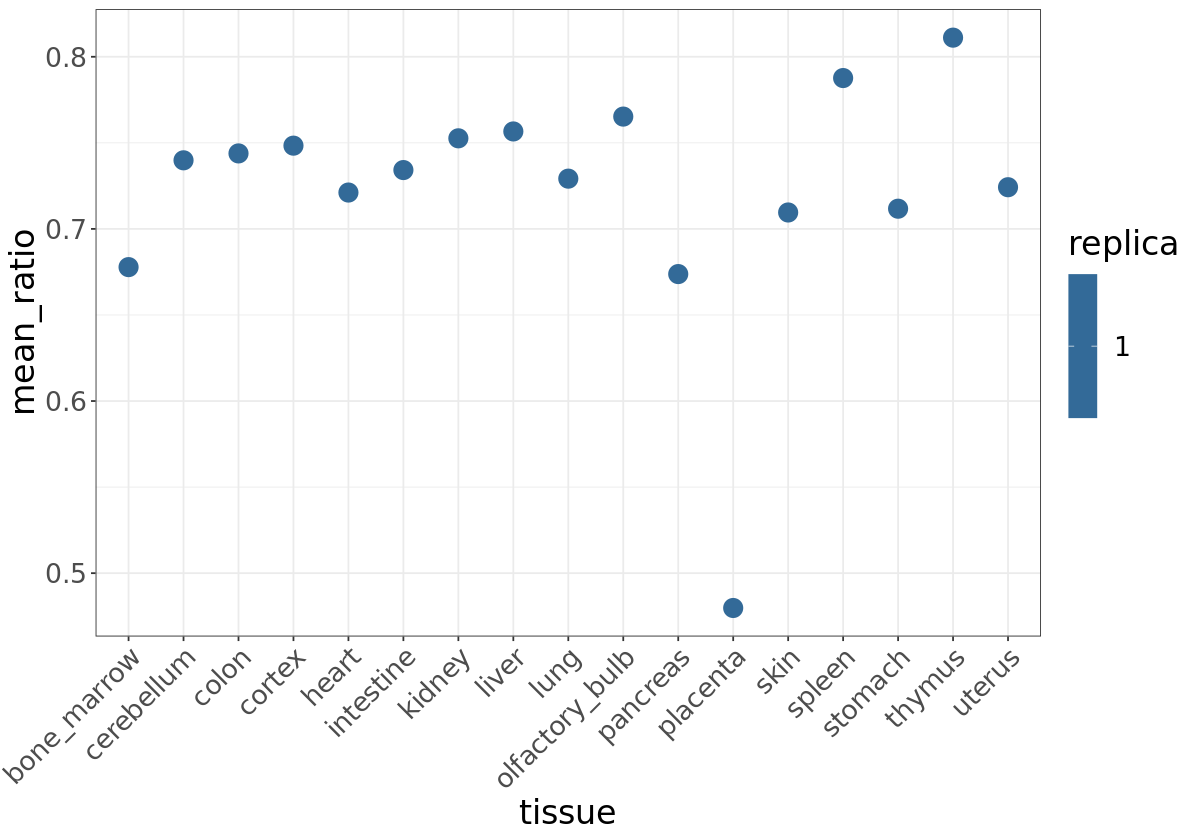

In [17]:
options(repr.plot.width = 10)
ggplot(mean_ratio, aes(x = tissue, y = mean_ratio, color = replica)) + geom_point(size = 5) + 
                            theme_bw() + theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1))

## Data type 4 - allC
### Lancelet-1 (only one sample)

In [82]:
files_list <- paste0("../../resources/WGBS_public/Branchiostoma_lanceolatum_1/", list.files("../../resources/WGBS_public/Branchiostoma_lanceolatum_1/", pattern = "*allC.txt", recursive = T))

Column 1 - assembly (chromosome).column 2 - position: coordinate for the cytosine position on the chromosome (first base of chromosome = 0).column 3 - strand: + or - strand.column 4 - class: context of the cytosine and the two following bases from the same strand.column 5 - mc: number of reads supporting a methylated cytosine.column 6 - h: total number of reads at that position.  
**data is filtered by the coverage value > 5 and 

In [83]:
df <- fread(files_list[[1]], header = FALSE) #change to fread, way faster
head(df)

V1,V2,V3,V4,V5,V6
<chr>,<int>,<chr>,<chr>,<int>,<int>
Sc0000000,5,+,CHH,0,1
Sc0000000,15,+,CHH,0,1
Sc0000000,28,+,CHG,0,1
Sc0000000,39,+,CHH,1,1
Sc0000000,48,+,CHH,0,2
Sc0000000,51,+,CHH,0,2


In [84]:
colnames(df) <- c("chr", "position", "strand", "threenucl_context", "mC_count", "coverage")

In [85]:
unique(df$threenucl_context)

[1] "CHH" "CHG" "CG"

Filtering out non-CpG methylation

In [86]:
df <- df[threenucl_context=="CG"]

In [87]:
head(df)

chr,position,strand,threenucl_context,mC_count,coverage
<chr>,<int>,<chr>,<chr>,<int>,<int>
Sc0000000,81,+,CG,1,2
Sc0000000,213,+,CG,3,4
Sc0000000,220,+,CG,4,6
Sc0000000,221,-,CG,0,1
Sc0000000,228,+,CG,2,5
Sc0000000,229,-,CG,0,2


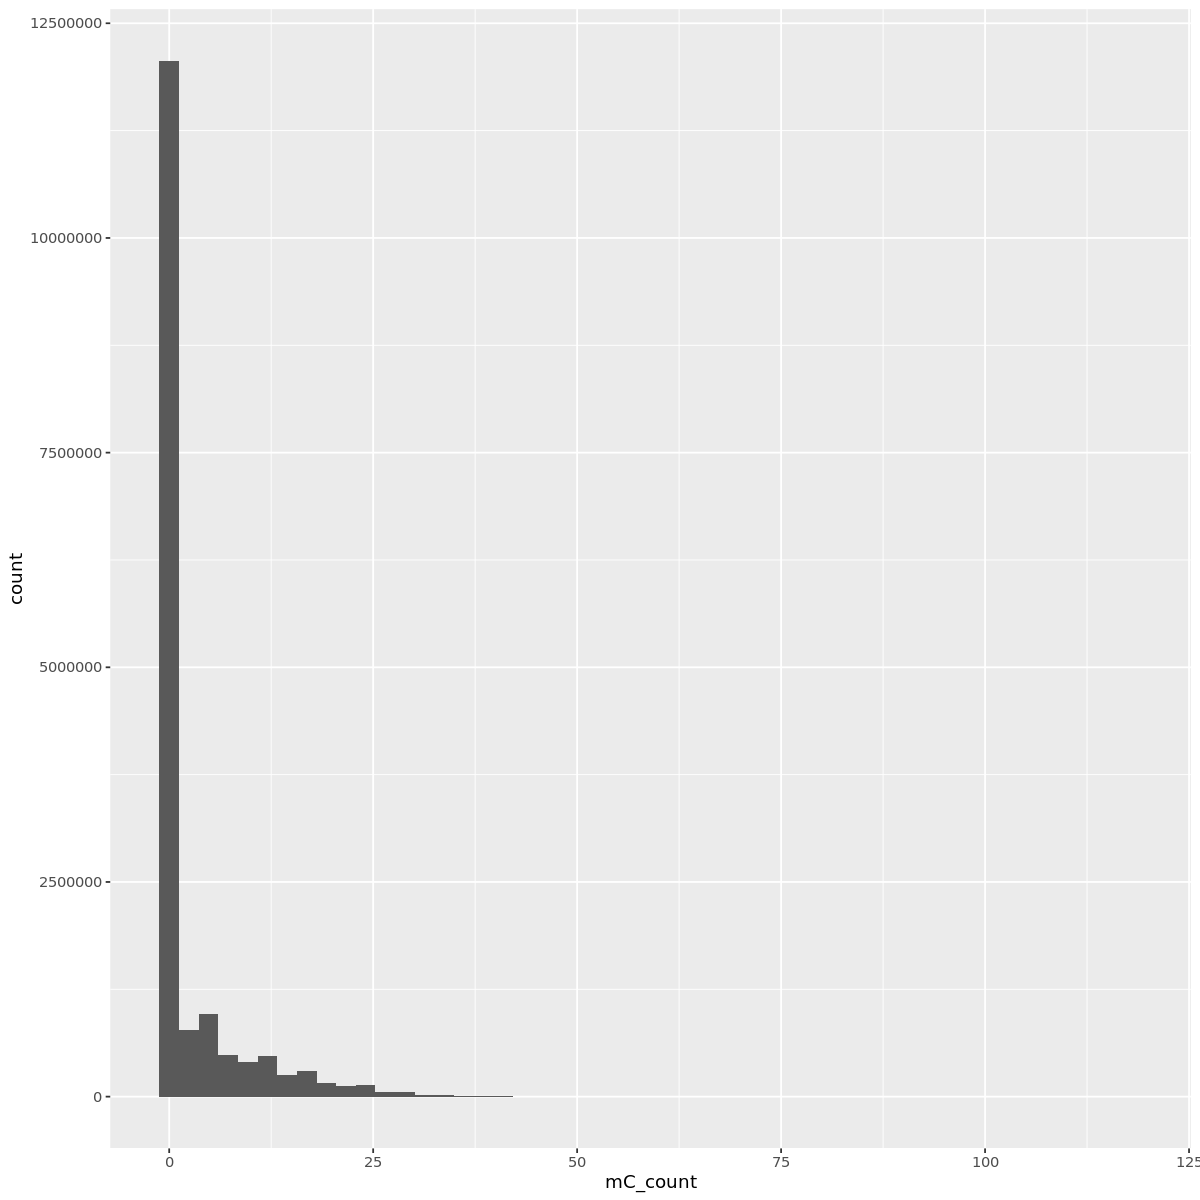

In [89]:
ggplot(df[coverage>2], aes(x = mC_count)) + geom_histogram(bins = 50)

In [90]:
df$meth_ratio = df$mC_count/df$coverage

In [91]:
df[,end:=position + 1,]

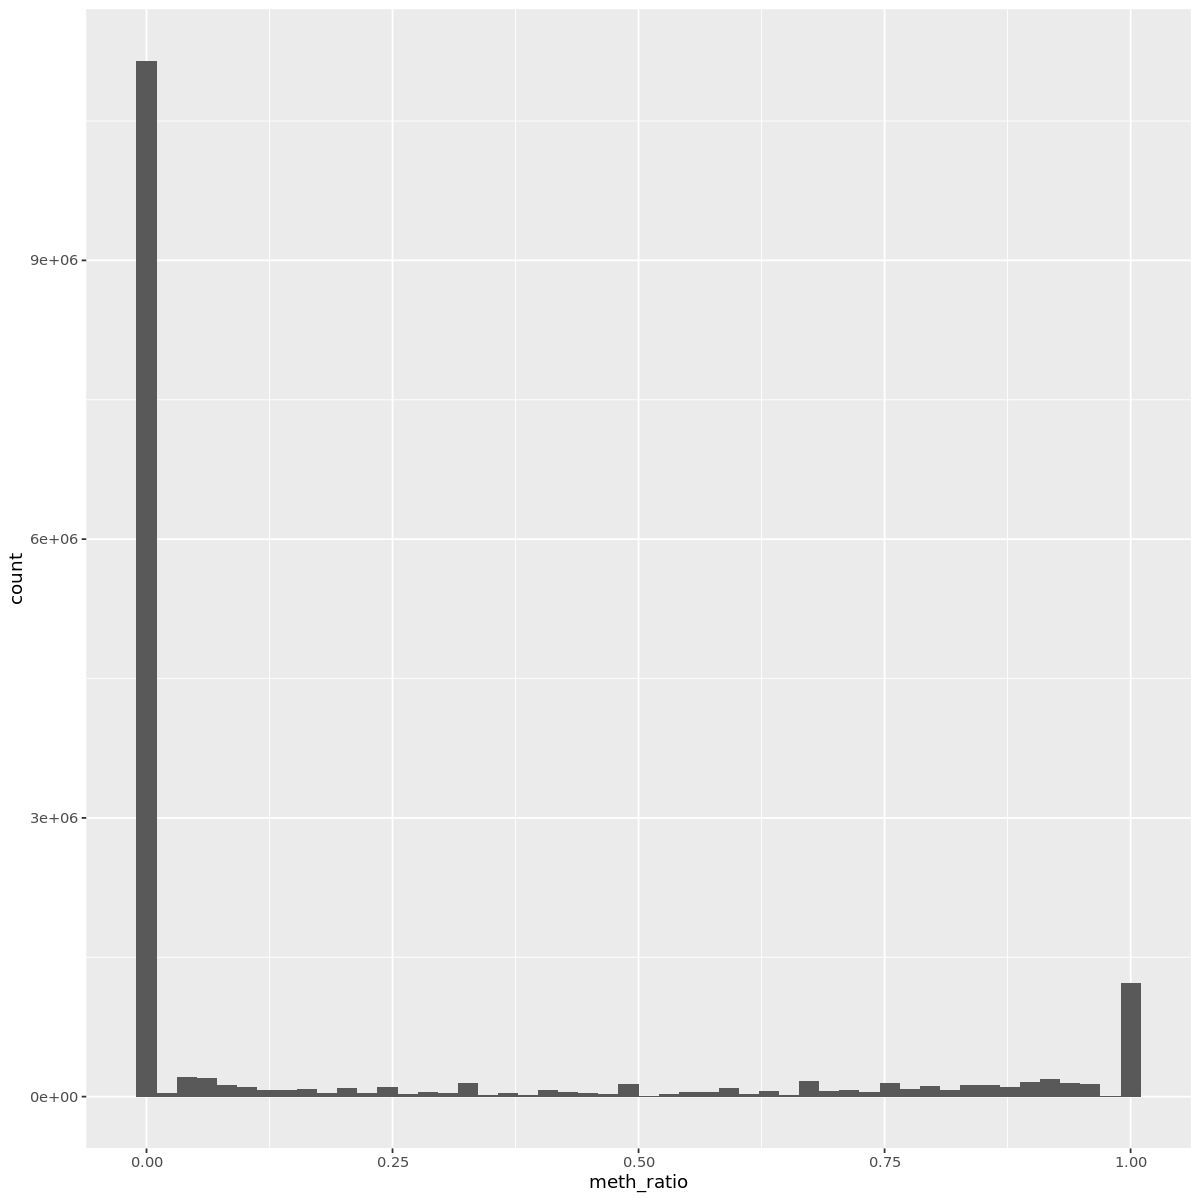

In [92]:
ggplot(df[coverage>2], aes(x = meth_ratio)) + geom_histogram(bins = 50)

In [107]:
dir.create("../validation/WGBS_public/prediction/Branchiostoma_lanceolatum")

In [108]:
files_list

[1] "../../resources/WGBS_public/Branchiostoma_lanceolatum_1/liver/GSM2728830_liver_MethylC_seq.allC.txt"

In [101]:
save_bed(df[,c("chr", "position", "end", "strand", "coverage", "meth_ratio")], "../../resources/WGBS_public/Branchiostoma_lanceolatum/GSM2728830_liver.bed")

In [113]:
annot <- data.frame(path = files_list, 
           tissue = "liver",
           replica = "GSE102144")

In [114]:
annot

path,tissue,replica
<fct>,<fct>,<fct>
../../resources/WGBS_public/Branchiostoma_lanceolatum_1/liver/GSM2728830_liver_MethylC_seq.allC.txt,liver,GSE102144


In [12]:
df <- df[coverage > 5, ]

In [18]:
mean_ratio = data.table(path = files_list[[1]], mean_ratio = mean(df$meth_ratio), replica = 1, tissue = "liver", genomeid = "Branchiostoma_lanceolatum_1")

In [20]:
write.table(mean_ratio, "../validation/WGBS_public/Branchiostoma_lanceolatum_GSE102144.csv", sep = ";", quote = F, row.names = F)

## Data type 5 - Cdepth
### oyster

 Tab-delimited text file that contains all of the cytosines of the whole genome, one cytosine per line.  
###### Format:
###### col1: scaffoldID
###### col2: position of the cytosine
###### col3: context of the cytosine 
###### col4: type of the cytosine 
###### col5: strand of the cytosine
###### col6: number of unique reads supporting methylation for replicate1
###### col7: number of unique reads supporting non-methylaion for replicate1
###### col8: number of mismatch for the base following the cytosine for replicate1, just used for filtering mCHGs and mCHHs.
###### col9: number of unique reads supporting methylation for replicate2
###### col10: number of unique reads supporting non-methylaion for replicate2
###### col11: number of mismatch for the base following the cytosine for replicate2, just used for filtering mCHGs and mCHHs.
###### col12: p value of binomial distribution before adjusting by FDR for repliate1
###### col13: p value of binomial distribution after adjusting by FDR for repliate1
###### col14: p value of binomial distribution before adjusting by FDR for repliate2
###### col15: p value of binomial distribution after adjusting by FDR for repliate2
###### col16: p value of binomial distribution before adjusting by FDR for union
###### col17: p value of binomial distribution after adjusting by FDR for union

###### Notice:
###### For mC detection, a cytosine is detected as mC if the p value of binomial distribution after adjusting by FDR is less than 0.01 .

In [2]:
files_list <- paste0("../../resources/WGBS_public/Crassostrea_gigas/", list.files("../../resources/WGBS_public/Crassostrea_gigas/", pattern = "*Cdepth.txt", recursive = T))

In [3]:
files_list[[1]]

[1] "../../resources/WGBS_public/Crassostrea_gigas/mantle_mantle_of_the_inbred_individual/GSM991064_Inbred.Cdepth.txt"

In [4]:
annot <- data.frame(path = files_list, 
           tissue = "mantle",
           replica = as.character(sapply(files_list, function(x) strsplit(x, "_")[[1]][7] )))
head(annot)

,path,tissue,replica
,<fct>,<fct>,<fct>
1,../../resources/WGBS_public/Crassostrea_gigas/mantle_mantle_of_the_inbred_individual/GSM991064_Inbred.Cdepth.txt,mantle,inbred
2,../../resources/WGBS_public/Crassostrea_gigas/mantle_mantle_of_the_wild_individual/GSM991065_Wild.Cdepth.txt,mantle,wild


In [5]:
df <- fread(files_list[[1]], skip=26)
head(df)

#scaffoldID,position,context,type,strand,mC_dep(rep1),non_mC_dep(rep1),misMatch(rep1),mC_dep(rep2),non_mC_dep(rep2),misMatch(rep2),pval(rep1),adj_pval(rep1),pval(rep2),adj_pval(rep2),pval(union),adj_pval(union)
<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1,1,CGC,CG,+,0,0,0,0,0,0,1,1,1,1,1,1
C1,2,CGN,CG,-,0,0,0,0,0,0,1,1,1,1,1,1
C1,3,CTA,CHH,+,0,0,0,0,0,0,1,1,1,1,1,1
C1,6,CTA,CHH,-,0,0,0,0,0,0,1,1,1,1,1,1
C1,7,CGG,CG,+,0,0,0,0,0,0,1,1,1,1,1,1
C1,8,CGC,CG,-,0,0,0,0,0,0,1,1,1,1,1,1


In [6]:
unique(df$type)

[1] "CG"  "CHH" "CHG" "CNN" "CHN" "CNG"

In [ ]:
### extremly long - running as a script on the side
mean_ratio = data.table()
for(i in c(1:NROW(annot))){
    print(annot$path[[i]])
    df <- fread(as.character(annot$path[[i]]), skip = 26)
    print(NROW(df))
    df <- df[type == "CG"]
    
    colnames(df)[6] <- "mC_dep_rep1"
    colnames(df)[7] <- "non_mC_dep_rep1"
    
    colnames(df)[9] <- "mC_dep_rep2"
    colnames(df)[10] <- "non_mC_dep_rep2"
    
    df$total_rep1 = df$mC_dep_rep1 + df$nonmC_dep_rep1
    df$total_rep2 = df$mC_dep_rep2 + df$nonmC_dep_rep2
 
    
    ## mean in repl 1:
    df_r1 <- df[total_rep1 > 5]
    df_r1$meth_ratio = df_r1$mC_dep_rep1/df_r1$total_rep1
   
    mean_r1 = mean(df_r1$meth_ratio)
    
    
    
    ## mean in repl 2:
    df_r2 <- df[total_rep2 > 5]
    df_r2$meth_ratio = df_r2$mC_dep_rep2/df_r2$total_rep2
   
    mean_r2 = mean(df_r2$meth_ratio)
    
    
    mean_ratio <- rbind(mean_ratio, data.frame(path = as.character(annot$path[[i]]), mean_ratio = c(mean_r1, mean_r2), repl = c(1, 2)))
}

mean_ratio <- left_join(mean_ratio, annot)

mean_ratio <- left_join(mean_ratio, annot)
mean_ratio$replica <- paste0(mean_ratio$replica, "_", mean_ratio$repl)
                                         
write.table(mean_ratio[,-3], "../validation/WGBS_public/Crassostrea_gigas_GSE40302.csv", sep = ";", quote = F, row.names = F)

In [2]:
#run separly (see Cdepth.R)
mean_ratio <- read.csv( "../validation/WGBS_public/Crassostrea_gigas_GSE40302.csv", sep = ";")
head(mean_ratio)

,path,mean_ratio,tissue,replica
,<fct>,<dbl>,<fct>,<fct>
1,../../resources/WGBS_public/Crassostrea_gigas/mantle_mantle_of_the_inbred_individual/GSM991064_Inbred.Cdepth.txt,0.1108978,mantle,inbred_1
2,../../resources/WGBS_public/Crassostrea_gigas/mantle_mantle_of_the_inbred_individual/GSM991064_Inbred.Cdepth.txt,0.1207489,mantle,inbred_2
3,../../resources/WGBS_public/Crassostrea_gigas/mantle_mantle_of_the_wild_individual/GSM991065_Wild.Cdepth.txt,0.1150189,mantle,wild_1
4,../../resources/WGBS_public/Crassostrea_gigas/mantle_mantle_of_the_wild_individual/GSM991065_Wild.Cdepth.txt,0.1198798,mantle,wild_2


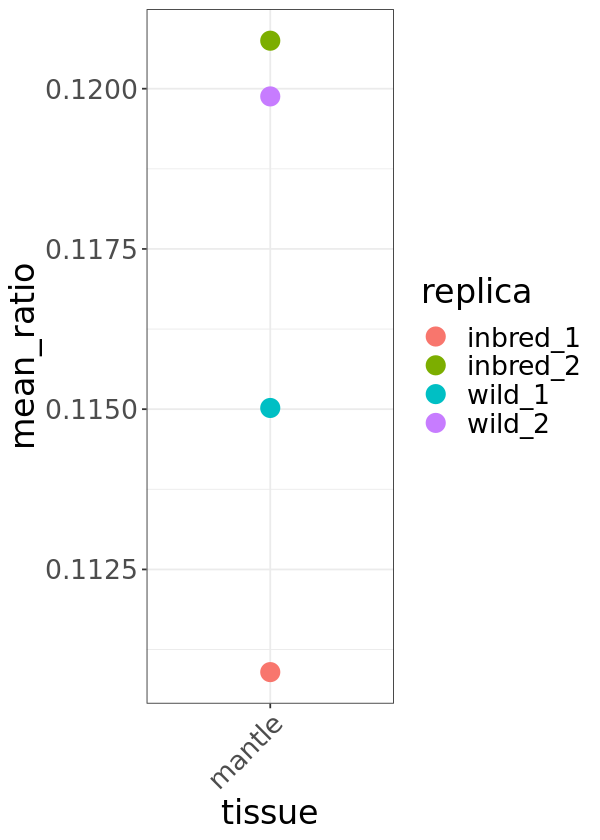

In [4]:
options(repr.plot.width = 5)
ggplot(mean_ratio, aes(x = tissue, y = mean_ratio, color = replica)) + geom_point(size = 5) + 
                            theme_bw() + theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1))

## Data type 6 - CGmap
### large brain study across animals
contain chromosome position, (1) chromosome (2) nucleotide on Watson (+) strand (3) position (4) context (CG/CHG/CHH) (5) dinucleotide-context (CA/CC/CG/CT) (6) methylation-level = #_of_C / (#_of_C + #_of_T). (7) #_of_C (methylated C, the count of reads showing C here) (8) = #_of_C + #_of_T (all Cytosines, the  sum of reads showing C or T in that position).

In [115]:
files_list <- paste0("../../resources/WGBS_public/", list.files("../../resources/WGBS_public/", pattern = "*.CGmap", recursive = T))

In [12]:
annot <- data.frame(path = files_list, 
           organism = as.character(sapply(files_list, function(x) strsplit(x, "/")[[1]][5])),
           tissue = as.character(sapply(files_list, function(x) strsplit(x, "/")[[1]][6])),
           replica = 1)
head(annot)

,path,organism,tissue,replica
,<fct>,<fct>,<fct>,<dbl>
1,../../resources/WGBS_public/Apis_mellifera/brain/GSM4209497_mC_brain_queen_honeybee.CGmap,Apis_mellifera,brain,1
2,../../resources/WGBS_public/Branchiostoma_lanceolatum/Neural_tube/GSM4209500_mC_NeuralTube_amphioxus.CGmap,Branchiostoma_lanceolatum,Neural_tube,1
3,../../resources/WGBS_public/Callorhinchus_milii/brain/GSM4209495_mC_brain_elephant_shark.CGmap,Callorhinchus_milii,brain,1
4,../../resources/WGBS_public/Danio_rerio/forebrain/GSM4209494_mC_forebrain_zebrafish.CGmap,Danio_rerio,forebrain,1
5,../../resources/WGBS_public/Gallus_gallus/brain/GSM4209493_mC_brain_chicken.CGmap,Gallus_gallus,brain,1
6,../../resources/WGBS_public/Lethenteron_camtschaticum/brain/GSM4209496_mC_brain_arctic_lamprey.CGmap,Lethenteron_camtschaticum,brain,1


saving only lancelet :) 

In [117]:
files_list[[2]]

[1] "../../resources/WGBS_public/Branchiostoma_lanceolatum/Neural_tube/GSM4209500_mC_NeuralTube_amphioxus.CGmap"

In [122]:
annot <- rbind(annot, data.frame(path = files_list[[2]], 
           tissue = "Neural_tube",
           replica = "GSE141609"))

In [123]:
write.table(annot, "../../resources/WGBS_public/Branchiostoma_lanceolatum/WGBS_annot.csv", row.names = FALSE, quote = FALSE, sep = ";")

In [119]:
i <- 2
df <- fread(as.character(files_list[[i]]))
colnames(df) <- c("chr", "nucleotide", "position", "context", "dinucl_context", "meth_level", "meth_read_count", "all_C_count")
df <- df[context=="CG"]

In [120]:
head(df)

chr,nucleotide,position,context,dinucl_context,meth_level,meth_read_count,all_C_count
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<int>
chrL,C,4,CG,CG,0.00267380,1,374
chrL,G,5,CG,CG,0.00172117,1,581
chrL,C,7,CG,CG,0.00531915,2,376
chrL,G,8,CG,CG,0.00343053,2,583
chrL,C,13,CG,CG,0.00522193,2,383
chrL,G,14,CG,CG,0.00000000,0,592


In [124]:
df[, end:=position + 1, ]

In [127]:
save_bed_nostrand(df[,c("chr", "position", "end", "all_C_count", "meth_level")], "../validation/WGBS_public/prediction/Branchiostoma_lanceolatum/GSM4209500_mC_NeuralTube.bed")

In [ ]:
mean_ratio = data.table()
for(i in c(1:NROW(annot))){
    print(annot$path[[i]])
    df <- fread(as.character(annot$path[[i]]))
    print(NROW(df))
    colnames(df) <- c("chr", "nucleotide", "position", "context", "dinucl_context", "meth_level", "meth_read_count", "all_C_count")
    df <- df[context=="CG"]
    df <- df[all_C_count > 5]
    mean_ratio <- rbind(mean_ratio, data.frame(path = as.character(annot$path[[i]]), mean_ratio = mean(df$meth_level)))
}

mean_ratio <- left_join(mean_ratio, annot)
write.table(mean_ratio, "../validation/WGBS_public/Combined_study_GSE141609.csv", sep = ";", quote = F, row.names = F)

In [ ]:
head(mean_ratio)

In [9]:
mean_ratio <- read.csv("../validation/WGBS_public/Combined_study_GSE141609.csv", sep = ";")
head(mean_ratio)

,path,mean_ratio,organism,tissue,replica
,<fct>,<dbl>,<fct>,<fct>,<int>
1,../../resources/WGBS_public/Apis_mellifera/brain/GSM4209497_mC_brain_queen_honeybee.CGmap,0.00670899,Apis_mellifera,brain,1
2,../../resources/WGBS_public/Branchiostoma_lanceolatum/Neural_tube/GSM4209500_mC_NeuralTube_amphioxus.CGmap,0.18028377,Branchiostoma_lanceolatum,Neural_tube,1
3,../../resources/WGBS_public/Callorhinchus_milii/brain/GSM4209495_mC_brain_elephant_shark.CGmap,0.72717153,Callorhinchus_milii,brain,1
4,../../resources/WGBS_public/Danio_rerio/forebrain/GSM4209494_mC_forebrain_zebrafish.CGmap,0.79482579,Danio_rerio,forebrain,1
5,../../resources/WGBS_public/Gallus_gallus/brain/GSM4209493_mC_brain_chicken.CGmap,0.63933483,Gallus_gallus,brain,1
6,../../resources/WGBS_public/Lethenteron_camtschaticum/brain/GSM4209496_mC_brain_arctic_lamprey.CGmap,0.45868410,Lethenteron_camtschaticum,brain,1


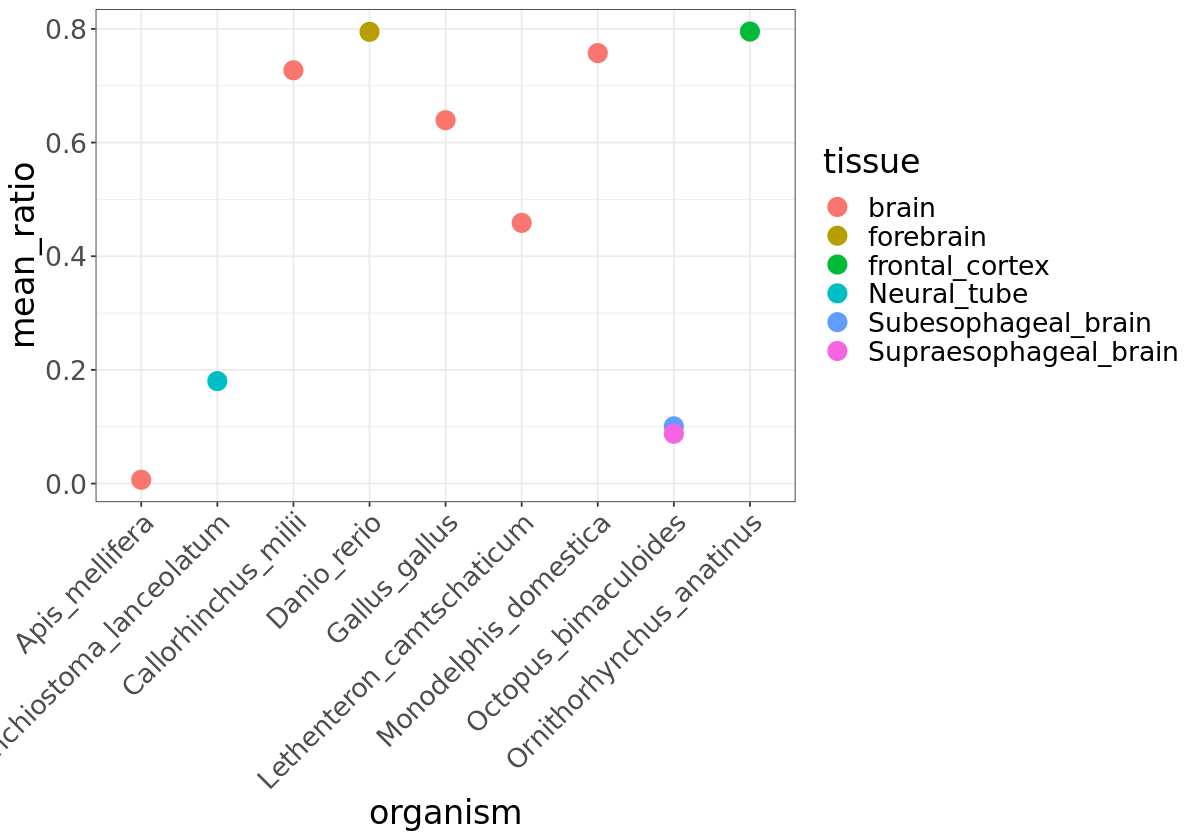

In [13]:
options(repr.plot.width = 10)
ggplot(mean_ratio, aes(x = organism, y = mean_ratio, color = tissue)) + geom_point(size = 5) + 
                            theme_bw() + theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1))

## Data type 7 - gemBS output
Zebrafish processed from the raw data (gemBS pipeline, ran by Bekir)  
File description is at: http://statgen.cnag.cat/GEMBS/UserGuide/_build/html/pipelineExtract.html - ENCODE BED9+5 bedMethyl format


In [5]:
annot <- fread("../../resources/WGBS_public/Danio_rerio_gemBS/BSX_0021_Zebrafish_WGBS_wgbs_gembs_samples.csv")
head(annot)

raw_file_GSM,tissue,replica,sample_name,barcode,dataset,flowcell,lane,platform,center,file1,file2,library,type
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM4824409,heart,1,GSM4824409_heart_1,SRR12797058,SRR12797058,NA,NA,HiSeq,external,SRR12797058_1.fastq,SRR12797058_2.fastq,GSE149416,Paired
GSM4824410,heart,2,GSM4824410_heart_2,SRR12797059,SRR12797059,NA,NA,HiSeq,external,SRR12797059_1.fastq,SRR12797059_2.fastq,GSE149416,Paired
GSM4824411,intestine,1,GSM4824411_intestine_1,SRR12797060,SRR12797060,NA,NA,HiSeq,external,SRR12797060_1.fastq,SRR12797060_2.fastq,GSE149416,Paired
GSM4824412,intestine,2,GSM4824412_intestine_2,SRR12797061,SRR12797061,NA,NA,HiSeq,external,SRR12797061_1.fastq,SRR12797061_2.fastq,GSE149416,Paired
GSM4824413,skin,1,GSM4824413_skin_1,SRR12797062,SRR12797062,NA,NA,HiSeq,external,SRR12797062_1.fastq,SRR12797062_2.fastq,GSE149416,Paired
GSM4824414,skin,2,GSM4824414_skin_2,SRR12797063,SRR12797063,NA,NA,HiSeq,external,SRR12797063_1.fastq,SRR12797063_2.fastq,GSE149416,Paired


In [6]:
annot[, path:=paste0("../../resources/WGBS_public/Danio_rerio_gemBS/extract/", dataset, "_cpg.bed.gz"),]

In [7]:
annot[, path_bed:=paste0("../../resources/WGBS_public/Danio_rerio_", library,"/", sample_name, ".bed"),]

In [8]:
colnames(annot)[16] <- "path_unif" 

In [9]:
head(annot)

raw_file_GSM,tissue,replica,sample_name,barcode,dataset,flowcell,lane,platform,center,file1,file2,library,type,path,path_unif
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM4824409,heart,1,GSM4824409_heart_1,SRR12797058,SRR12797058,NA,NA,HiSeq,external,SRR12797058_1.fastq,SRR12797058_2.fastq,GSE149416,Paired,../../resources/WGBS_public/Danio_rerio_gemBS/extract/SRR12797058_cpg.bed.gz,../../resources/WGBS_public/Danio_rerio_GSE149416/GSM4824409_heart_1.bed
GSM4824410,heart,2,GSM4824410_heart_2,SRR12797059,SRR12797059,NA,NA,HiSeq,external,SRR12797059_1.fastq,SRR12797059_2.fastq,GSE149416,Paired,../../resources/WGBS_public/Danio_rerio_gemBS/extract/SRR12797059_cpg.bed.gz,../../resources/WGBS_public/Danio_rerio_GSE149416/GSM4824410_heart_2.bed
GSM4824411,intestine,1,GSM4824411_intestine_1,SRR12797060,SRR12797060,NA,NA,HiSeq,external,SRR12797060_1.fastq,SRR12797060_2.fastq,GSE149416,Paired,../../resources/WGBS_public/Danio_rerio_gemBS/extract/SRR12797060_cpg.bed.gz,../../resources/WGBS_public/Danio_rerio_GSE149416/GSM4824411_intestine_1.bed
GSM4824412,intestine,2,GSM4824412_intestine_2,SRR12797061,SRR12797061,NA,NA,HiSeq,external,SRR12797061_1.fastq,SRR12797061_2.fastq,GSE149416,Paired,../../resources/WGBS_public/Danio_rerio_gemBS/extract/SRR12797061_cpg.bed.gz,../../resources/WGBS_public/Danio_rerio_GSE149416/GSM4824412_intestine_2.bed
GSM4824413,skin,1,GSM4824413_skin_1,SRR12797062,SRR12797062,NA,NA,HiSeq,external,SRR12797062_1.fastq,SRR12797062_2.fastq,GSE149416,Paired,../../resources/WGBS_public/Danio_rerio_gemBS/extract/SRR12797062_cpg.bed.gz,../../resources/WGBS_public/Danio_rerio_GSE149416/GSM4824413_skin_1.bed
GSM4824414,skin,2,GSM4824414_skin_2,SRR12797063,SRR12797063,NA,NA,HiSeq,external,SRR12797063_1.fastq,SRR12797063_2.fastq,GSE149416,Paired,../../resources/WGBS_public/Danio_rerio_gemBS/extract/SRR12797063_cpg.bed.gz,../../resources/WGBS_public/Danio_rerio_GSE149416/GSM4824414_skin_2.bed


In [12]:
write.table(annot[library == "GSE149416",c("path","path_unif","tissue","replica")], "../../resources/WGBS_public/Danio_rerio_GSE149416/WGBS_annot.csv", row.names = FALSE, quote = FALSE, sep = ";")

In [13]:
write.table(annot[library == "GSE134055",c("path","path_unif","tissue","replica")], "../../resources/WGBS_public/Danio_rerio_GSE134055/WGBS_annot.csv", row.names = FALSE, quote = FALSE, sep = ";")

In [28]:
mean_ratio = data.table()
for(i in c(1:NROW(annot[library == "GSE149416"]) + 1)){  ##processed the first & blood from the second
    print(annot$path[[i]])
    df <- fread(annot$path[[i]], skip = 1)
    save_bed(df[, c(1,2,3,6,10,11)], annot$path_bed[[i]])
    mean_r = mean(df[V10 > 5]$V11)
    mean_ratio <- rbind(mean_ratio, data.frame(path = annot$path[[i]], mean_ratio = mean_r))
    }   

Here we have two files for each run, making it even more fun!

In [51]:
mean_ratio <- left_join(mean_ratio, annot)

Joining, by = "path"



In [56]:
write.table(mean_ratio[library == "GSE149416",],  "../validation/WGBS_public/Danio_rerio_GSE149416.csv", sep = ";", quote = F, row.names = F)

In [57]:
mean_ratio <- mean_ratio[library == "GSE134055",c(path, mean_ratio)]

In [61]:
mean_ratio

path,mean_ratio
<fct>,<dbl>
../../resources/WGBS_public/Danio_rerio_gemBS/extract/SRR12173554_cpg.bed.gz,76.22891


In [40]:
annot_double <- annot[c((NROW(annot[library == "GSE149416"])+2):NROW(annot))]

In [66]:
df1 <- fread(annot_double$path[[1]], skip =1)

In [67]:
df2 <- fread(annot_double$path[[2]], skip = 1)

In [68]:
head(df1)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>
chr1,81,82,GSM4662071_Brain_1,3,+,81,82,"255,0,0",3,100,CG,MG,2
chr1,82,83,GSM4662071_Brain_1,5,-,82,83,"255,0,0",5,100,CG,CK,20
chr1,92,93,GSM4662071_Brain_1,3,+,92,93,"255,155,0",3,66,CG,CG,19
chr1,93,94,GSM4662071_Brain_1,6,-,93,94,"255,105,0",6,83,CG,CG,16
chr1,149,150,GSM4662071_Brain_1,11,+,149,150,"255,55,0",11,90,CG,CG,42
chr1,150,151,GSM4662071_Brain_1,6,-,150,151,"255,105,0",6,83,CG,CG,40


In [69]:
head(df2)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>
chr1,81,82,GSM4662071_Brain_1,4,+,81,82,"255,0,0",4,100,CG,CG,11
chr1,82,83,GSM4662071_Brain_1,1,-,82,83,"255,0,0",1,100,CG,CG,11
chr1,92,93,GSM4662071_Brain_1,5,+,92,93,"255,105,0",5,80,CG,CG,8
chr1,93,94,GSM4662071_Brain_1,2,-,93,94,"255,255,0",2,50,CG,CG,14
chr1,149,150,GSM4662071_Brain_1,5,+,149,150,"255,0,0",5,100,CG,CG,23
chr1,150,151,GSM4662071_Brain_1,4,-,150,151,"255,0,0",4,100,CG,CG,26


In [70]:
colnames(df1)[c(1:3)] <- c("chr", "start", "end")
colnames(df2)[c(1:3)] <- c("chr", "start", "end")

In [73]:
colnames(df1)[6] <- "strand"
colnames(df2)[6] <- "strand"

In [76]:
colnames(df1)[c(10,11)] <- c("coverage_1", "perc_1")
colnames(df2)[c(10,11)] <- c("coverage_2", "perc_2")

In [77]:
df <- full_join(df1[, c("chr", "start", "end","strand", "coverage_1", "perc_1" )], df2[, c("chr", "start", "end","strand", "coverage_2", "perc_2" )])

Joining, by = c("chr", "start", "end", "strand")



In [98]:
head(df)

chr,start,end,strand,coverage_1,perc_1,coverage_2,perc_2,cov_total,perc_total
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>
chr1,81,82,+,3,100,4,100,7,100.000
chr1,82,83,-,5,100,1,100,6,100.000
chr1,92,93,+,3,66,5,80,8,74.750
chr1,93,94,-,6,83,2,50,8,74.750
chr1,149,150,+,11,90,5,100,16,93.125
chr1,150,151,-,6,83,4,100,10,89.800


In [92]:
weighted.mean(c(100,100), c(3,4))

[1] 100

In [84]:
df[is.na(coverage_1), coverage_1 :=0, ]

In [85]:
df[is.na(coverage_2), coverage_2 :=0, ]

In [86]:
df[, cov_total := coverage_1 + coverage_2, ]

In [97]:
df[,perc_total:= weighted.mean(c(perc_1, perc_2), c(coverage_1, coverage_2)), by = list(chr, start, end)]

In [101]:
save_bed(df[,c("chr", "start", "end", "strand", "cov_total", "perc_total")], annot_double$path_bed[1])

In [102]:
mean_r = mean(df$perc_total)

In [103]:
mean_r

[1] 78.32336

In [1]:
mean_ratio

ERROR: Error in eval(expr, envir, enclos): object 'mean_ratio' not found


In [105]:
mean_ratio <- rbind(mean_ratio, data.frame(path = annot_double$path[[1]], mean_ratio = mean_r))

In [ ]:
for(i in seq(3, NROW(annot_double), 2)){
    print(annot_double$path[[i]])
    df1 <- fread(annot$path[[i]], skip = 1)
    df2 <- fread(annot$path[[i+1]], skip = 1)
    ## transforming
    colnames(df1)[c(1:3)] <- c("chr", "start", "end")
    colnames(df2)[c(1:3)] <- c("chr", "start", "end")
    
    colnames(df1)[6] <- "strand"
    colnames(df2)[6] <- "strand"
    
    colnames(df1)[c(10,11)] <- c("coverage_1", "perc_1")
    colnames(df2)[c(10,11)] <- c("coverage_2", "perc_2")
    
    df <- full_join(df1[, c("chr", "start", "end","strand", "coverage_1", "perc_1" )], df2[, c("chr", "start", "end","strand", "coverage_2", "perc_2" )])
    
    df[is.na(coverage_1), coverage_1 :=0, ]
    df[is.na(coverage_2), coverage_2 :=0, ]
    
    df[, cov_total := coverage_1 + coverage_2, ]
    
    df[,perc_total:= weighted.mean(c(perc_1, perc_2), c(coverage_1, coverage_2)), by = list(chr, start, end)]
    save_bed(df[,c("chr", "start", "end", "strand", "cov_total", "perc_total")], annot_double$path_bed[1])
    
    
    mean_r = mean(df$perc_total)
    
    mean_ratio <- rbind(mean_ratio, data.frame(path = annot_double$path[[i]], mean_ratio = mean_r))
}

# RRBS-WGBS comparison
### Merge all together

In [3]:
 files_list <- paste0("../validation/WGBS_public/mean_WGBS_RRBS/", list.files("../validation/WGBS_public/mean_WGBS_RRBS/", pattern = "*.csv"))

In [4]:
files_list

[1] "../validation/WGBS_public/mean_WGBS_RRBS/Bos_taurus_GSE147087.csv"               
[2] "../validation/WGBS_public/mean_WGBS_RRBS/Branchiostoma_lanceolatum_GSE102144.csv"
[3] "../validation/WGBS_public/mean_WGBS_RRBS/Combined_study_GSE141609.csv"           
[4] "../validation/WGBS_public/mean_WGBS_RRBS/Crassostrea_gigas_GSE40302.csv"         
[5] "../validation/WGBS_public/mean_WGBS_RRBS/Danio_rerio_GSE134055.csv"              
[6] "../validation/WGBS_public/mean_WGBS_RRBS/Danio_rerio_GSE149416.csv"              
[7] "../validation/WGBS_public/mean_WGBS_RRBS/Gallus_gallus_GSE146620.csv"            
[8] "../validation/WGBS_public/mean_WGBS_RRBS/Mus_musculus_GSE42836.csv"              
[9] "../validation/WGBS_public/mean_WGBS_RRBS/Phascolarctos_cinereus_GSE149600.csv"

In [5]:
strsplit(path, "/")[[1]][5]

ERROR: Error in strsplit(path, "/"): object 'path' not found


In [49]:
wgbs_mean = data.table()
for(path in files_list){
        df <- read.csv(path, sep = ";")
    df$source <- gsub(".csv", "",strsplit(path, "/")[[1]][5])
    wgbs_mean <- rbind(df, wgbs_mean, fill = TRUE)
    }


In [50]:
wgbs_mean <- wgbs_mean[, c("path", "mean_ratio", "tissue","replica", "source")]

In [51]:
## clean-up of the tissue types
wgbs_mean[, latin_name:= sapply(wgbs_mean$path, function(x) strsplit(as.character(x), "/")[[1]][5]),]
wgbs_mean[latin_name == "Branchiostoma_lanceolatum_1", latin_name:= "Branchiostoma_lanceolatum",]
wgbs_mean[,tissue:=tolower(tissue),]
wgbs_mean[,tissue:=as.character(sapply(wgbs_mean$tissue, function(x) ifelse(length(grep("brain", x) > 0), "brain", x))),]
wgbs_mean[tissue == "frontal_cortex",tissue:="brain"]
wgbs_mean[tissue == "cerebellum",tissue:="brain"]
wgbs_mean[tissue == "right_hemisphere_cerebral_lobe",tissue:="brain"]
wgbs_mean[tissue == "olfactory_bulb",tissue:="brain"]                                      

In [52]:
wgbs_mean[source== "Danio_rerio_GSE134055", replica:=3,]

In [80]:
wgbs_mean[latin_name== "Branchiostoma_lanceolatum"]

path,mean_ratio,tissue,replica,source,latin_name,Species,color_class,English,m_rrbs,min_rrbs,max_rrbs
<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
../../resources/WGBS_public/Branchiostoma_lanceolatum/Neural_tube/GSM4209500_mC_NeuralTube_amphioxus.CGmap,0.1802838,neural_tube,2,Combined_study_GSE141609,Branchiostoma_lanceolatum,FLA,Invertebrata,Florida lancelet,28.22465,26.23361,31.93868
../../resources/WGBS_public/Branchiostoma_lanceolatum_1/liver/GSM2728830_liver_MethylC_seq.allC.txt,0.2018966,liver,1,Branchiostoma_lanceolatum_GSE102144,Branchiostoma_lanceolatum,FLA,Invertebrata,Florida lancelet,28.22465,26.23361,31.93868


In [54]:
match <- fread("../validation/WGBS_public/WGBS_RRBS_match.txt")

In [55]:
unique(wgbs_mean$latin_name)

[1] "Phascolarctos_cinereus"    "Mus_musculus"             
 [3] "Gallus_gallus"             "Danio_rerio_gemBS"        
 [5] "Crassostrea_gigas"         "Apis_mellifera"           
 [7] "Branchiostoma_lanceolatum" "Callorhinchus_milii"      
 [9] "Danio_rerio"               "Lethenteron_camtschaticum"
[11] "Monodelphis_domestica"     "Octopus_bimaculoides"     
[13] "Ornithorhynchus_anatinus"  "Bos_taurus"

In [56]:
wgbs_mean[latin_name=="Danio_rerio",replica:=4]

In [57]:
wgbs_mean[latin_name=="Danio_rerio_gemBS", latin_name:="Danio_rerio",]

In [58]:
wgbs_mean[latin_name=="Branchiostoma_lanceolatum" & source == "Combined_study_GSE141609", replica:=2,]

In [59]:
head(match)

organism,scientific name,n tisssues,n samples,Individuals,meth call,study link,mean methylation,prediction from sequence,individual vs. tissue,⋯,genome,CG call type,Species,genomeid,description of the suppl file,meth_ratio,comment,genome_to_use,V21,V22
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>
zebrafish 1,Danio rerio,4,8,2 (potentially pooled),no (bw),GSE149416,yes,yes,limited,⋯,GRCz11,raw,ZF,,,,,,NA,
zebrafish 2,Danio rerio,11,11,likely pooled,no (bw),GSE134055,yes,yes,no,⋯,GRCz10,raw,ZF,,,,,,NA,
cow,bos taurus,14,23,3,yes,GSE147087,yes,yes,yes,⋯,ARS-UCD1.2,CpG_report,ANW,Bos_taurus,"The column names are: chrmosome, position,strand, coverage for methylated cytosine, coverage for unmethylated cytosine, CG type, three bases near the cytosine.","filter met_count + unmeth_count > 0, meth_count/(meth_count + unmeth_count)",not exact match - subgroup,https://www.ensembl.org/Bos_taurus/Info/Index?db=core,NA,
mouse,mus musculus,17,17,1,yes,GSE42836,yes,yes,no,⋯,mm9,CpG.calls,MOU,Mus_musculus,"The processed tables indicate the number of methylated cytosines, total sequencing depth, and %mCG for each CpG dinucleotide, combined over both Watson and Crick strands","cov >5, use %mC",,BSgenome.Mmusculus.UCSC.mm9,NA,
lancet 1,Branchiostoma lanceolatum,1,1,1,yes,GSE102144,yes,yes,no,⋯,Bl71nemr,allC,FLA,Branchiostoma lanceolatum_1,Column 1 - assembly (chromosome).column 2 - position: coordinate for the cytosine position on the chromosome (first base of chromosome = 0).column 3 - strand: + or - strand.column 4 - class: context of the cytosine and the two following bases from the same strand.column 5 - mc: number of reads supporting a methylated cytosine.column 6 - h: total number of reads at that position.,filter cov > 5 and the context should be CG*,not exact match,https://www.ncbi.nlm.nih.gov/assembly/GCA_900088365.1,NA,mou
chicken 1,Gallus gallus,4,42,7,yes,GSE146620,yes,yes,yes,⋯,galGal5,cpg & coverage,CHK,Gallus_gallus,per CpG coverage and methylation ratio,"provided, filtered: cov > 5",,BSgenome.Ggallus.UCSC.galGal5,NA,


In [60]:
colnames(match)

[1] "organism"                      "scientific name"              
 [3] "n tisssues"                    "n samples"                    
 [5] "Individuals"                   "meth call"                    
 [7] "study link"                    "mean methylation"             
 [9] "prediction from sequence"      "individual vs. tissue"        
[11] "match in RRBS"                 "comment"                      
[13] "genome"                        "CG call type"                 
[15] "Species"                       "genomeid"                     
[17] "description of the suppl file" "meth_ratio"                   
[19] "comment"                       "genome_to_use"                
[21] "V21"                           "V22"

In [61]:
match[,latin_name := sapply(`scientific name`, function(x) paste(strsplit(x, " ")[[1]], collapse = "_")), ]

In [62]:
match[,latin_name :=sapply(latin_name, function(x) paste0(toupper(substr(x, 1,1)), substr(x, 2,nchar(x)))),]

In [63]:
wgbs_mean <- inner_join(wgbs_mean, unique(match[, c("latin_name", "Species")]))

Joining, by = "latin_name"



In [64]:
wgbs_mean[latin_name== "Branchiostoma_lanceolatum"]

path,mean_ratio,tissue,replica,source,latin_name,Species
<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>,<chr>
../../resources/WGBS_public/Branchiostoma_lanceolatum/Neural_tube/GSM4209500_mC_NeuralTube_amphioxus.CGmap,0.1802838,neural_tube,2,Combined_study_GSE141609,Branchiostoma_lanceolatum,FLA
../../resources/WGBS_public/Branchiostoma_lanceolatum_1/liver/GSM2728830_liver_MethylC_seq.allC.txt,0.2018966,liver,1,Branchiostoma_lanceolatum_GSE102144,Branchiostoma_lanceolatum,FLA


In [65]:
class_colors <- c("Invertebrata" = "#cfcfcf",
                  "Chondrichthyes" = "#F68383", 
                  "Actinopteri" = "#EA4142",
                  "Amphibia" = "#5AB349",
                  "Reptilia" = "#8761AC",
                  "Aves"="#FE9222",
                  "Marsupialia"="#8EBFDA",
                  "Mammalia"="#4892C2")

In [66]:
stats_annot <- read.csv("/nobackup/lab_bock/projects/DNAmeth500species/results_analysis_v1/01_basicStats/stats_annot.tsv", sep = "\t")
stats_annot[stats_annot$English == "Common Octopus",]$English <- "Common octopus" #temp fix, should dissapear after the rerun

In [67]:
colnames(stats_annot)

[1] "Fortlaufende.Nr"                    "Patho.Nr"                          
  [3] "scientific_name"                    "blast_species2"                    
  [5] "blast_species1"                     "Sample_Name_unif"                  
  [7] "Sample_Name"                        "species"                           
  [9] "total_reads"                        "mapped_reads"                      
 [11] "mapping_efficiency"                 "informative_reads"                 
 [13] "CpG_meth"                           "avg_meth"                          
 [15] "CpG_measurements"                   "coveredCpGs"                       
 [17] "conversionRate"                     "k1_unmeth"                         
 [19] "k3_meth"                            "totalMeasurements_k1"              
 [21] "totalMeasurements_k3"               "total_reads_untrimmed"             
 [23] "X.CT.GG"                            "CGG"                               
 [25] "TGG"                                "X.CT.GA"                           
 [27] "CGA"                                "TGA"                               
 [29] "others"                             "all_bases_Mio"                     
 [31] "As"                                 "Ts"                                
 [33] "Cs"                                 "Gs"                                
 [35] "Ns"                                 "perc_As"                           
 [37] "perc_Ts"                            "perc_Cs"                           
 [39] "perc_Gs"                            "perc_Ns"                           
 [41] "fragments_ref"                      "fragments_uncovered"               
 [43] "fragments_uncovered_perc"           "max_cont_sp"                       
 [45] "max_cont"                           "cont"                              
 [47] "cont_rat"                           "blast_count1"                      
 [49] "blast_count2"                       "mean_overlap"                      
 [51] "min_overlap"                        "max_overlap"                       
 [53] "conversion_type"                    "res_mapRate_nonMotifReads"         
 [55] "min_overlap_perc"                   "max_overlap_perc"                  
 [57] "V1"                                 "English"                           
 [59] "Tierart"                            "sex"                               
 [61] "age"                                "Entnahme"                          
 [63] "Tissue"                             "Well_y"                            
 [65] "Well_x"                             "DNA..ng.µl."                       
 [67] "Volume..µl."                        "DNA.prep.date"                     
 [69] "comment"                            "Box"                               
 [71] "RRBS.status"                        "Experiment.ID"                     
 [73] "pre.BC_CT"                          "Enrichment.cycles"                 
 [75] "Pool"                               "Adapter"                           
 [77] "FlowCell"                           "lane"                              
 [79] "renamed"                            "Experiment_new.lib.prep"           
 [81] "pre.BC.CT_uc"                       "Adapter_uc"                        
 [83] "unconverted"                        "renamed_uc"                        
 [85] "Experiment_unconverted"             "enrichtment_uc"                    
 [87] "Flowcell_uc"                        "lane_uc"                           
 [89] "abbreviation_sp"                    "replicate"                         
 [91] "ncbi_name"                          "ncbi_id"                           
 [93] "ncbi_order"                         "ncbi_class"                        
 [95] "ncbi_group"                         "ncbi_id_blastS1"                   
 [97] "ncbi_name_blastS1"                  "ncbi_id_blastS2"                   
 [99] "ncbi_name_blastS2"                  "lowest_common_blastS1"             
[1

In [68]:
stats_annot_mean_meth  <- stats_annot %>% filter(conversion_type == "converted") %>% group_by(color_class, species, English) %>% 
                summarize(m_rrbs = mean(CpG_meth), min_rrbs =min(CpG_meth), max_rrbs=max(CpG_meth) )

`summarise()` has grouped output by 'color_class', 'species'. You can override using the `.groups` argument.



In [69]:
wgbs_mean <- inner_join(wgbs_mean, stats_annot_mean_meth, by = c("Species" = "species"))
#ordering by evolutionary classes
wgbs_mean$color_class <- factor(wgbs_mean$color_class, levels = names(class_colors))
wgbs_mean <- wgbs_mean[order(color_class), ]
wgbs_mean$Species <- factor(wgbs_mean$Species, levels = unique(wgbs_mean$Species))
wgbs_mean$English <- factor(wgbs_mean$English, levels = unique(wgbs_mean$English))

In [70]:
wgbs_mean[mean_ratio > 1, mean_ratio:=mean_ratio/100]

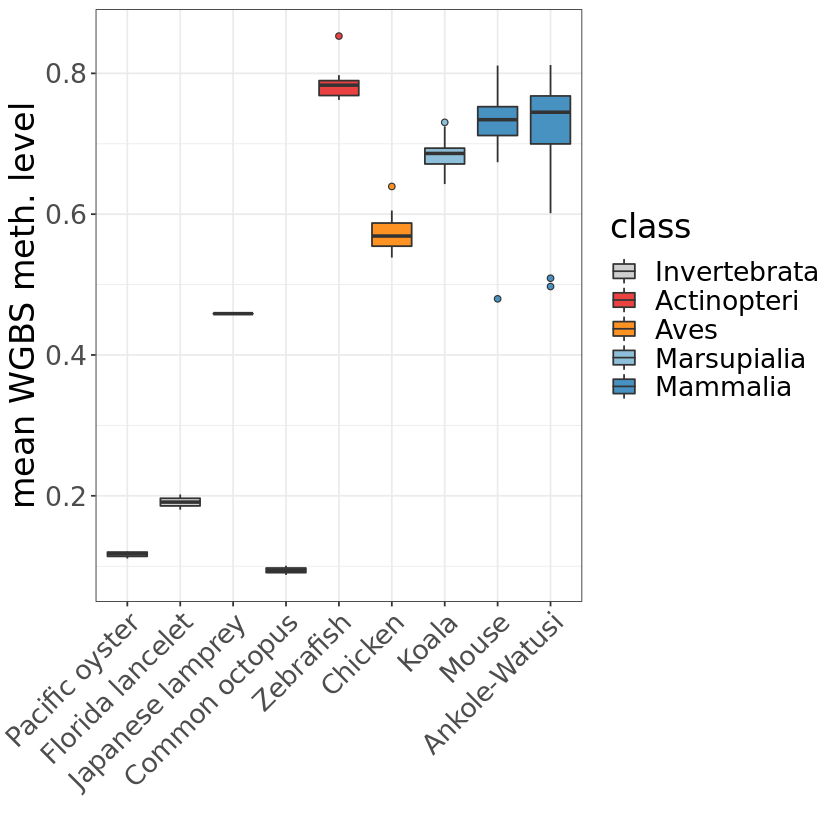

In [71]:
ggplot(wgbs_mean, aes(x = English, y = mean_ratio, fill = color_class)) + geom_boxplot(outlier.shape =  21) + theme_bw() + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_fill_manual(values = class_colors) + labs(x = "", y = "mean WGBS meth. level", fill = "class")
ggsave("../validation//WGBS_public/WGBS_boxplot.pdf", height = 6, width = 8)

In [72]:
wgbs_mean[Species== "KOA"]

path,mean_ratio,tissue,replica,source,latin_name,Species,color_class,English,m_rrbs,min_rrbs,max_rrbs
<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
../../resources/WGBS_public/Phascolarctos_cinereus/kidney/GSM4505502_WGM145_06_S3_kidney_PC_CpG_report.txt,0.6960289,kidney,1,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705
../../resources/WGBS_public/Phascolarctos_cinereus/kidney/GSM4505503_WGM145_08_S4_kidney_Ben_CpG_report.txt,0.6865759,kidney,2,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705
../../resources/WGBS_public/Phascolarctos_cinereus/lung/GSM4505504_WGM145_09_S5_lung_PC_CpG_report.txt,0.6868919,lung,1,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705
../../resources/WGBS_public/Phascolarctos_cinereus/lung/GSM4505505_WGM145_12_S6_lung_Ben_CpG_report.txt,0.6859269,lung,2,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705
../../resources/WGBS_public/Phascolarctos_cinereus/pancreas/GSM4505508_WGM145_19_S9_pancreas_PC_CpG_report.txt,0.6565745,pancreas,1,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705
../../resources/WGBS_public/Phascolarctos_cinereus/pancreas/GSM4505509_WGM145_20_S10_pancreas_Ben_CpG_report.txt,0.6427336,pancreas,2,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705
../../resources/WGBS_public/Phascolarctos_cinereus/Right_hemisphere_cerebral_lobe/GSM4505500_WGM145_01_S1_brain_PC_CpG_report.txt,0.7245443,brain,1,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705
../../resources/WGBS_public/Phascolarctos_cinereus/Right_hemisphere_cerebral_lobe/GSM4505501_WGM145_04_S2_brain_Ben_CpG_report.txt,0.7304078,brain,2,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705
../../resources/WGBS_public/Phascolarctos_cinereus/skeletal_muscle/GSM4505506_WGM145_14_S7_skeletal_muscle_PC_CpG_report.txt,0.6695120,skeletal_muscle,1,Phascolarctos_cinereus_GSE149600,Phascolarctos_cinereus,KOA,Marsupialia,Koala,55.81602,44.49499,67.13705


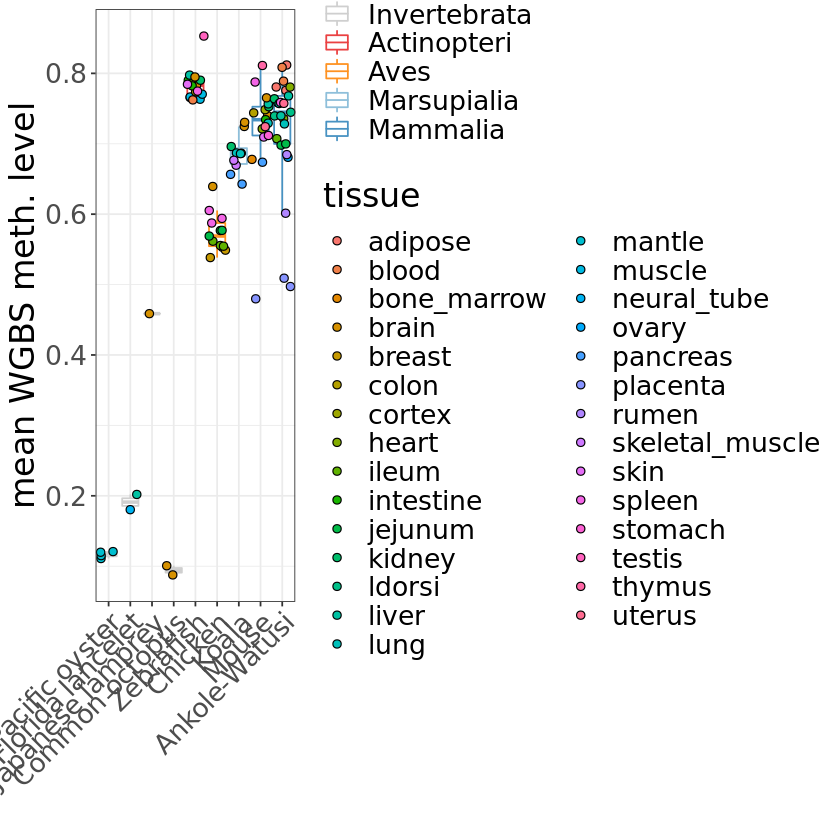

In [73]:
ggplot(wgbs_mean, aes(x = English, y = mean_ratio)) + geom_boxplot(outlier.shape = NA, aes(color = color_class)) + theme_bw() + 
geom_jitter(shape = 21, size = 2,aes(fill = tissue)) + scale_color_manual(values = class_colors) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) + labs(x = "", y = "mean WGBS meth. level", color = "class")
ggsave("../validation//WGBS_public/WGBS_boxplot_tissue.pdf", height = 8, width = 15)

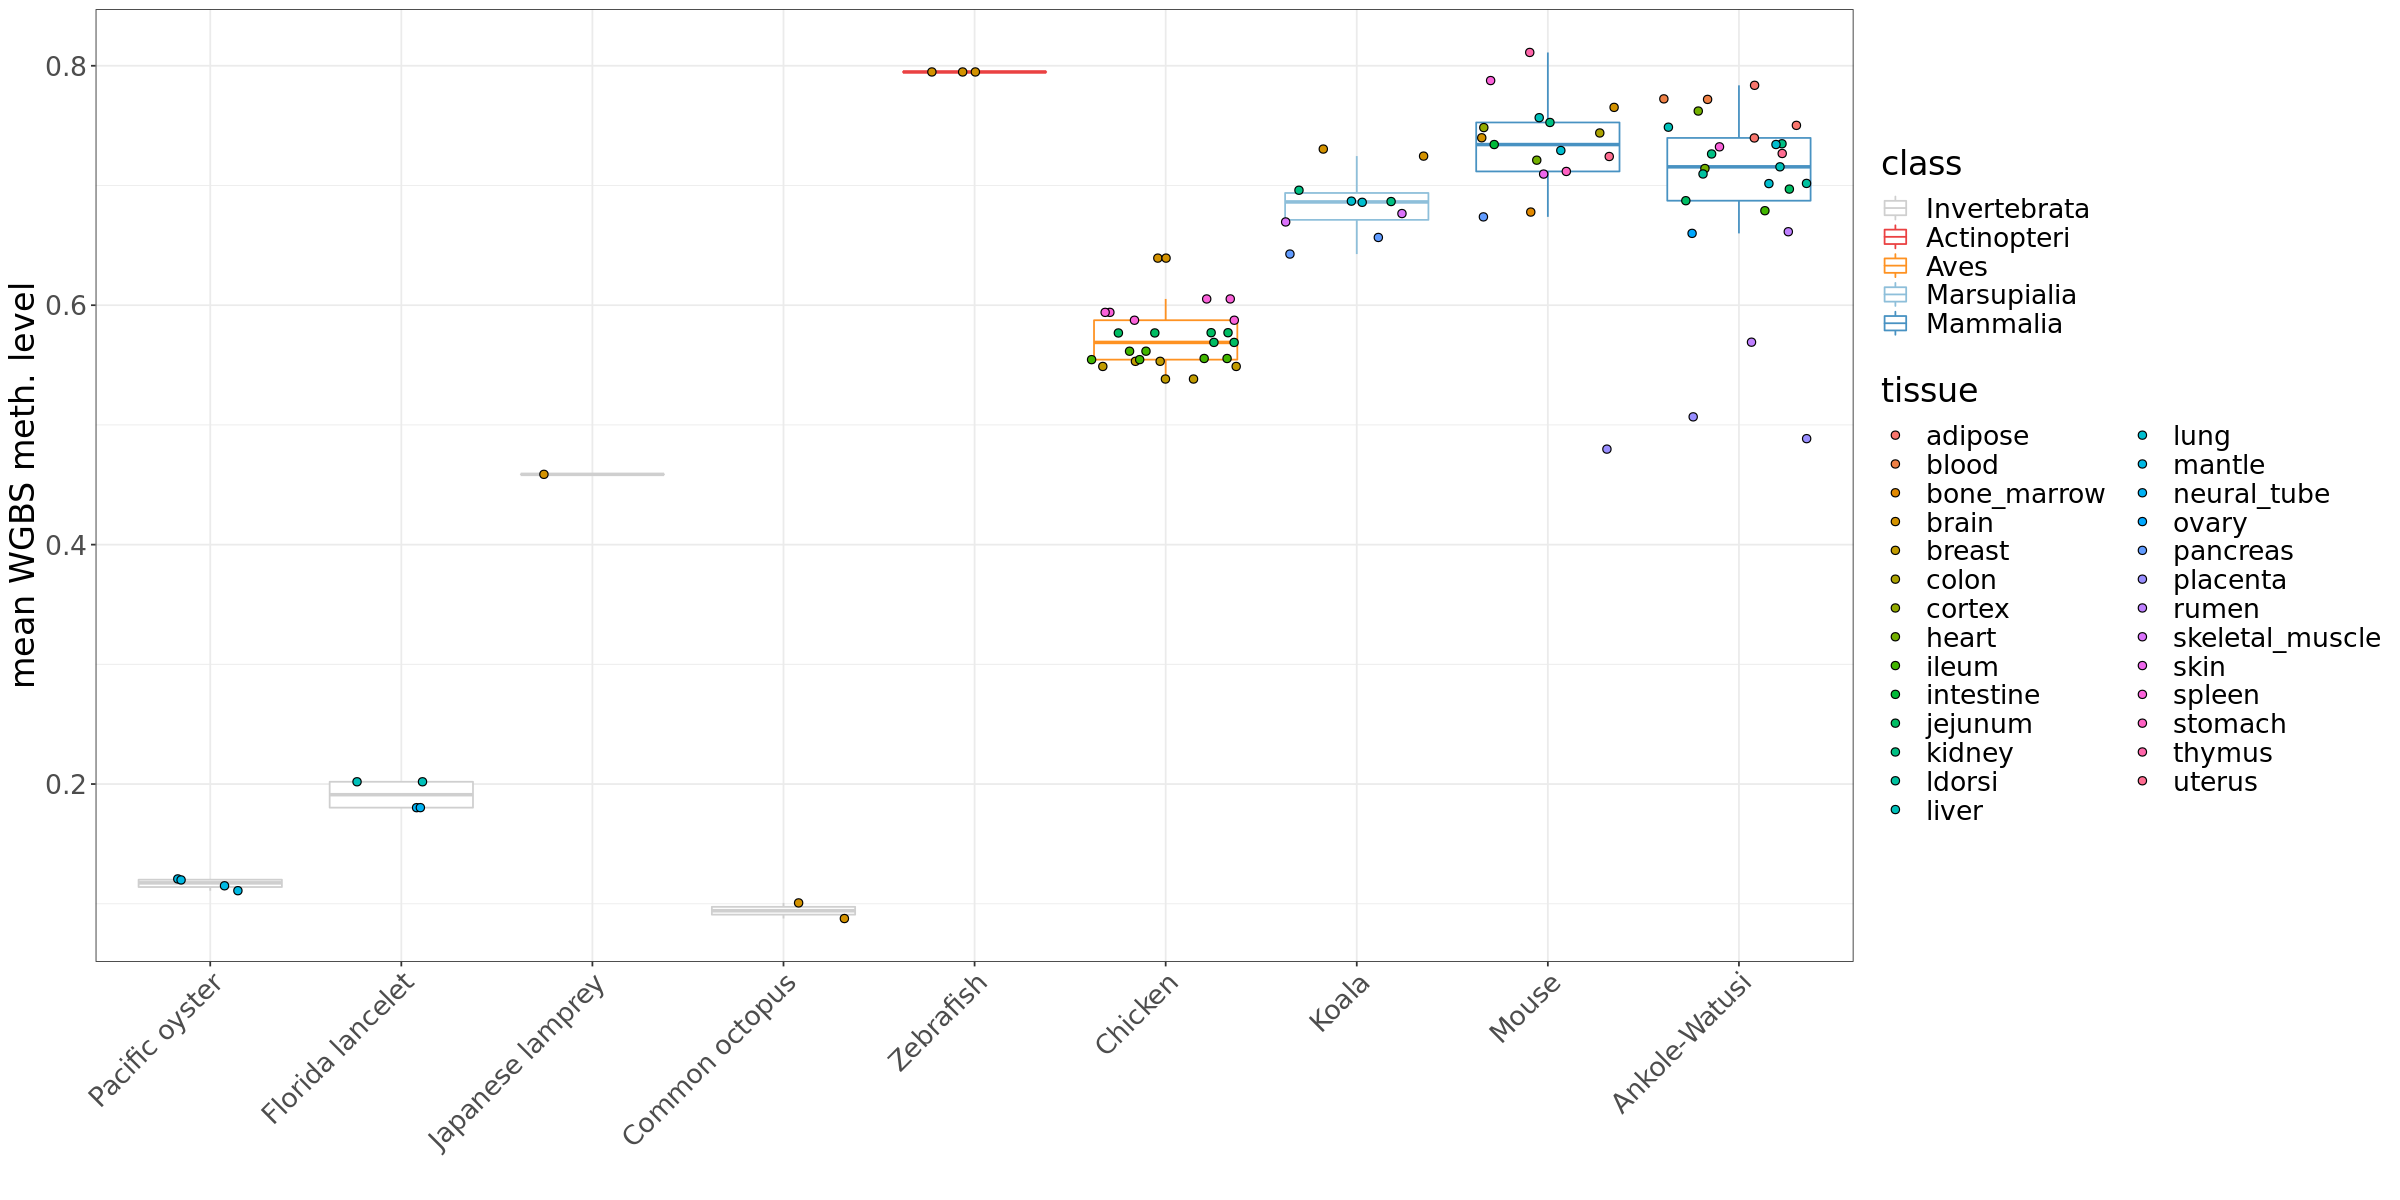

In [140]:
ggplot(wgbs_mean, aes(x = English, y = mean_ratio)) + geom_boxplot(outlier.shape = NA, aes(color = color_class)) + theme_bw() + 
geom_jitter(shape = 21, size = 2,aes(fill = tissue)) + scale_color_manual(values = class_colors) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) + labs(x = "", y = "mean WGBS meth. level", color = "class")
ggsave("../validation//WGBS_public/WGBS_boxplot_tissue.pdf", height = 8, width = 15)

In [74]:
wgbs_mean_per_tissue <- wgbs_mean %>% group_by(Species, latin_name, tissue, English) %>% summarize(m = mean(mean_ratio))

`summarise()` has grouped output by 'Species', 'latin_name', 'tissue'. You can override using the `.groups` argument.



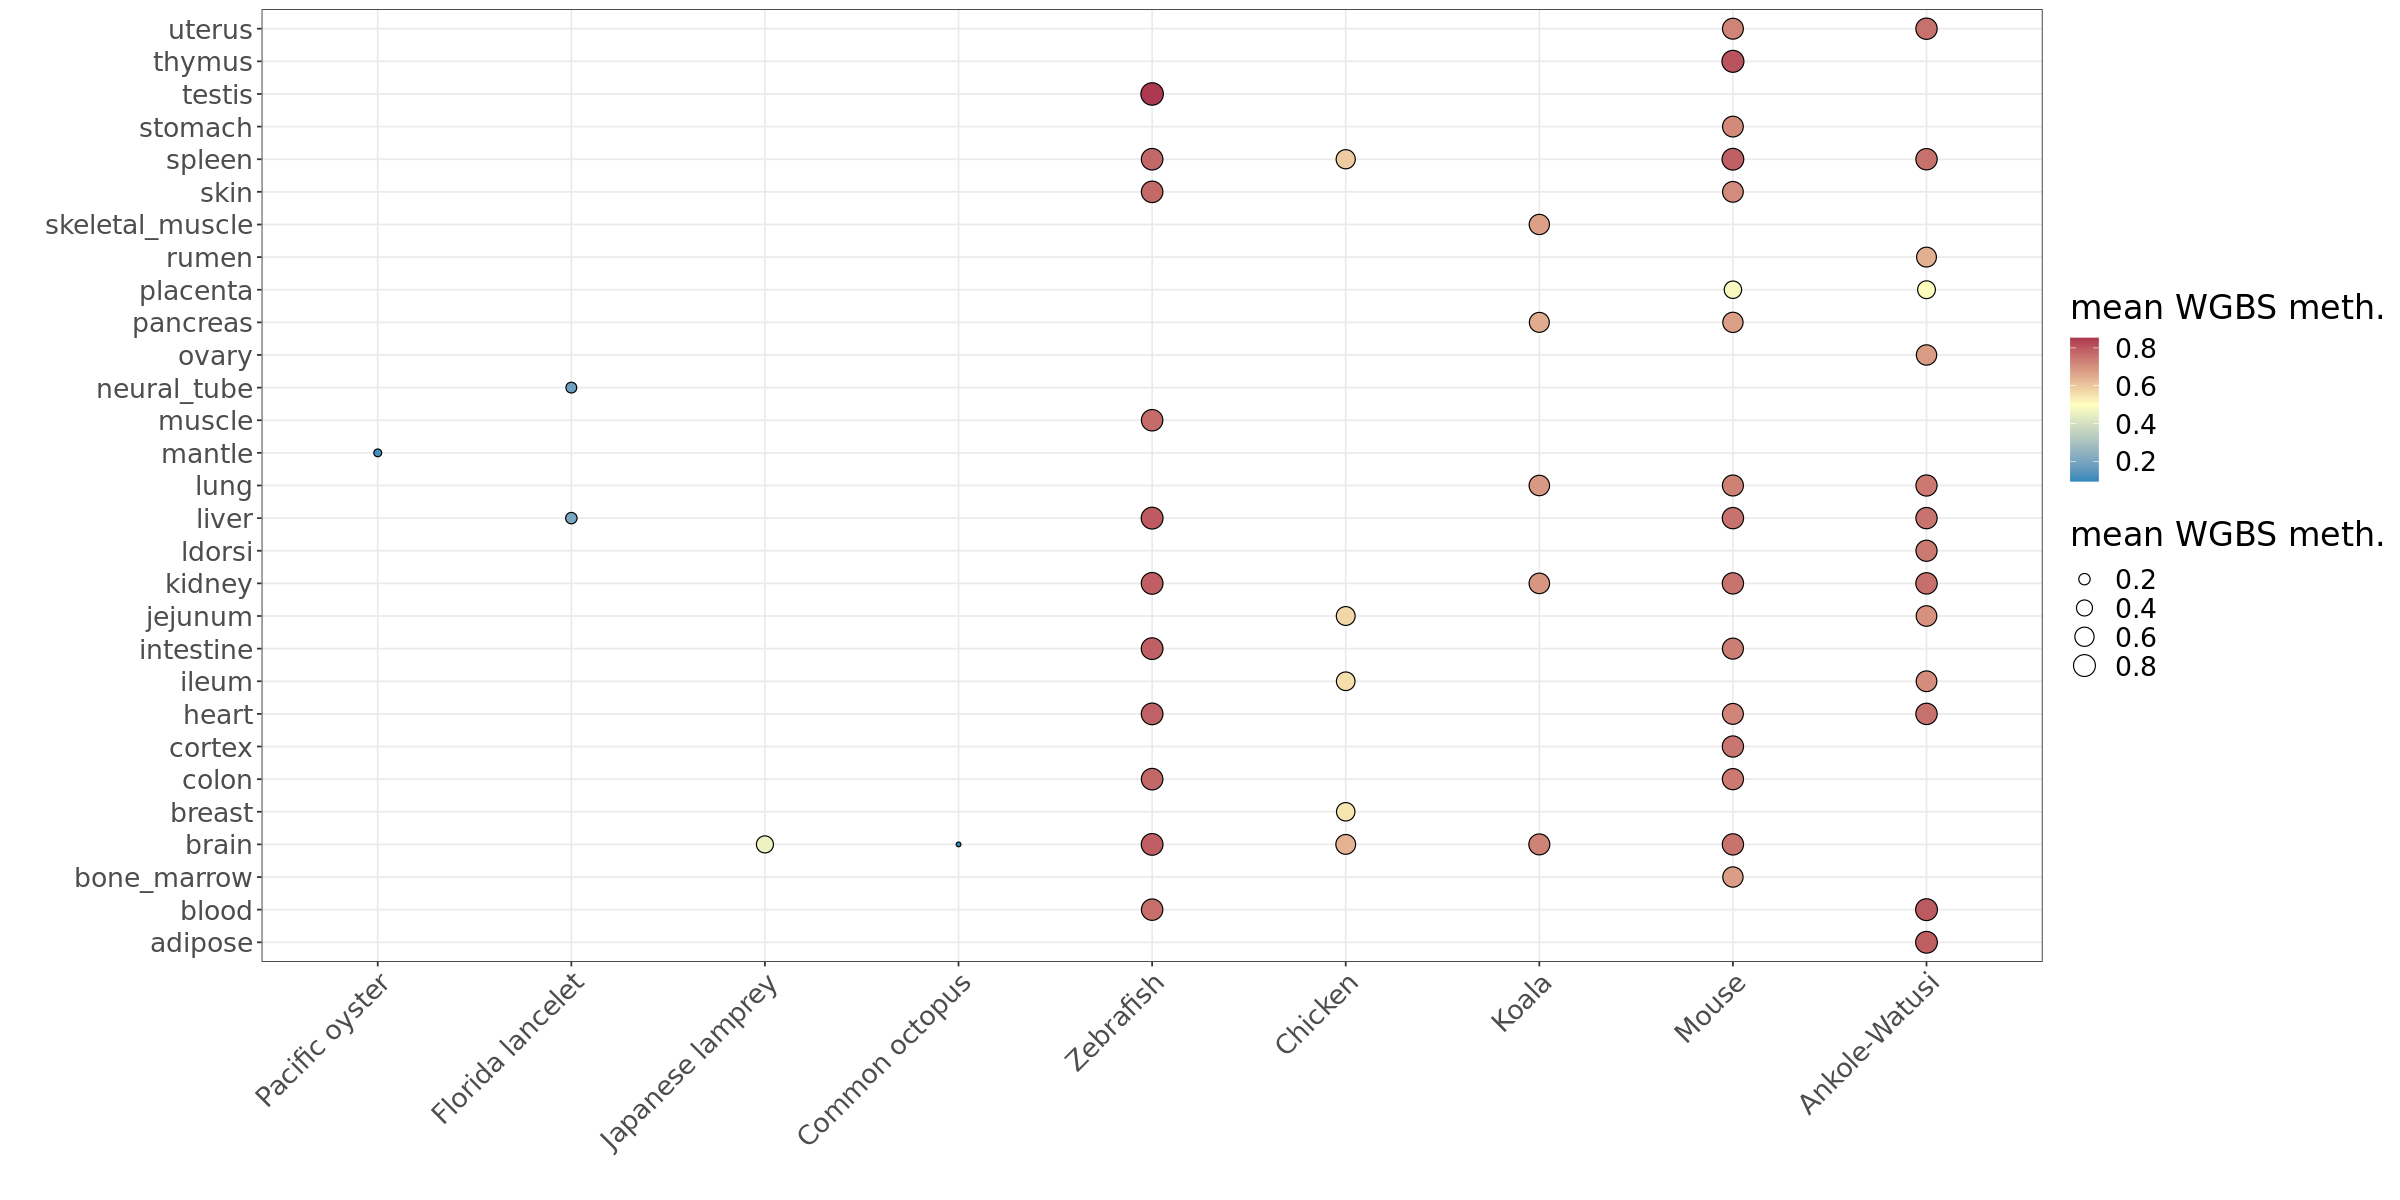

In [75]:
options(repr.plot.width = 20, repr.plot.height = 10)
ggplot(wgbs_mean_per_tissue, aes(x = English, y = tissue,fill = m, size = m)) + geom_point(shape = 21) + 
    theme_bw()+
    theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) + 
    scale_fill_gradient2(low = "#3288bd", mid = "#ffffbf", high = "#9e0142", midpoint = 0.5) + 
    labs(x = "", y = "", fill = "mean WGBS meth.", size = "mean WGBS meth." )
ggsave("../validation//WGBS_public/WGBS_mean_per_tissue.pdf", height = 10, width = 10)  

In [76]:
wgbs_mean_per_species <- wgbs_mean %>% filter(tissue!= "placenta") %>% group_by(latin_name, Species) %>% summarise(m_wgbs = mean(mean_ratio), min_wgbs = min(mean_ratio),
                                                                                                                   max_wgbs=max(mean_ratio), n = n())

`summarise()` has grouped output by 'latin_name'. You can override using the `.groups` argument.



In [77]:
wgbs_mean_per_species <- inner_join(wgbs_mean_per_species, stats_annot_mean_meth, by = c("Species" = "species"))

In [78]:
head(wgbs_mean_per_species)

latin_name,Species,m_wgbs,min_wgbs,max_wgbs,n,color_class,English,m_rrbs,min_rrbs,max_rrbs
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
Bos_taurus,ANW,0.7421149,0.6013491,0.8118369,23,Mammalia,Ankole-Watusi,52.88059,41.90812,63.85306
Branchiostoma_lanceolatum,FLA,0.1910902,0.1802838,0.2018966,2,Invertebrata,Florida lancelet,28.22465,26.23361,31.93868
Crassostrea_gigas,PAO,0.1166363,0.1108978,0.1207489,4,Invertebrata,Pacific oyster,13.26036,11.88358,13.89340
Danio_rerio,ZF,0.7830437,0.7622891,0.8529291,19,Actinopteri,Zebrafish,77.23642,74.88441,79.42004
Gallus_gallus,CHK,0.5738914,0.5383291,0.6393348,13,Aves,Chicken,35.04865,26.81022,51.00006
Lethenteron_camtschaticum,JL,0.4586841,0.4586841,0.4586841,1,Invertebrata,Japanese lamprey,60.89825,60.89825,60.89825


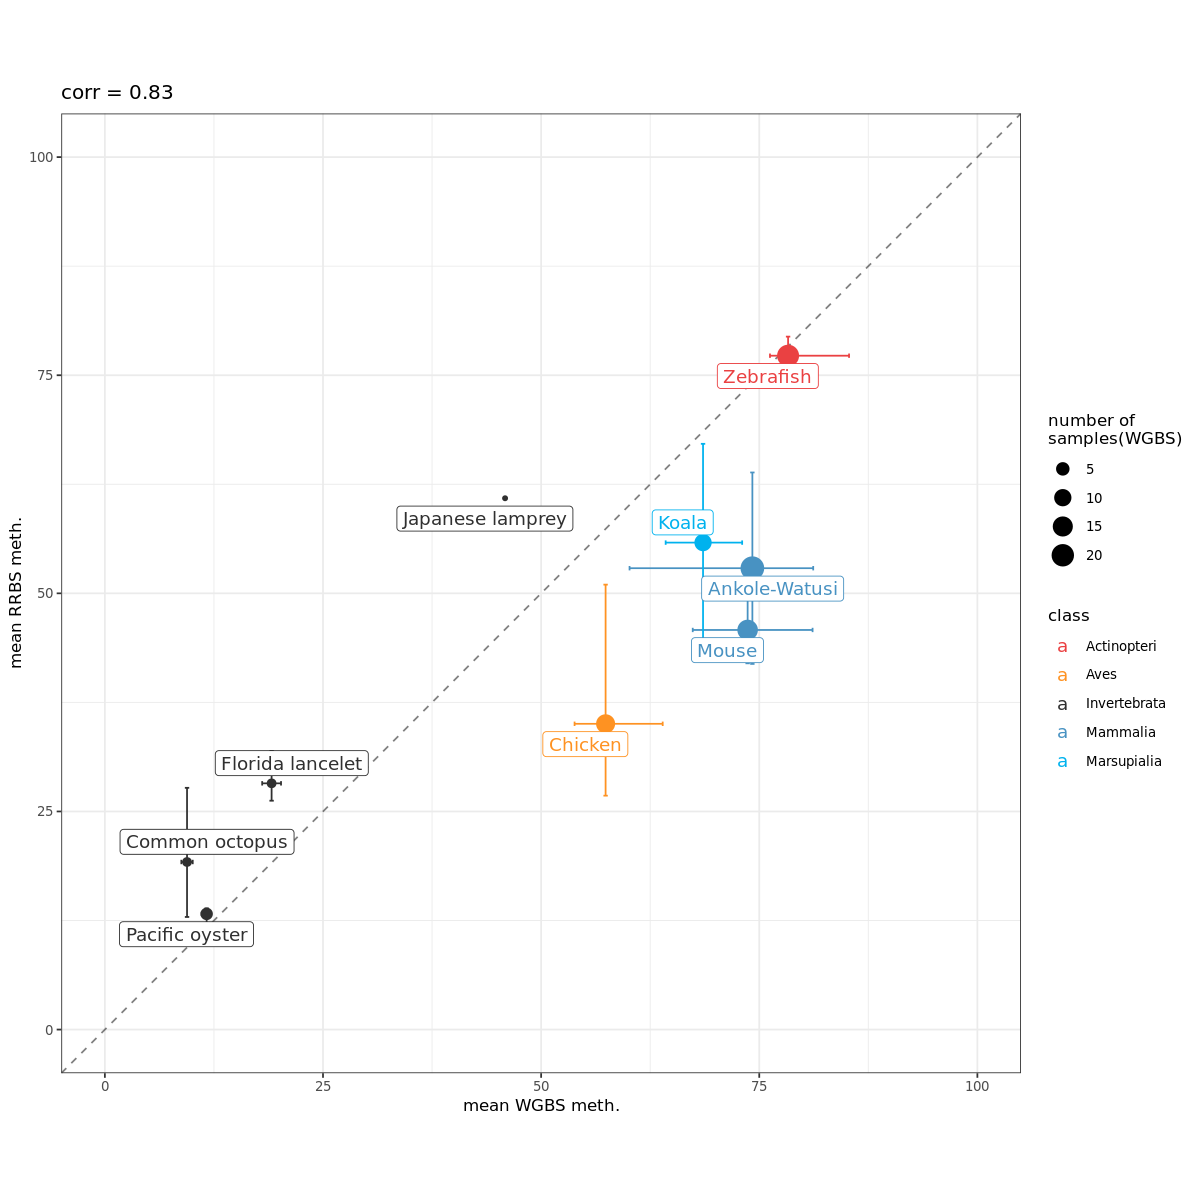

In [79]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(wgbs_mean_per_species, aes(x = m_wgbs*100, y = m_rrbs, color = color_class)) + 
geom_abline(slope = 1, alpha = 0.5, linetype = "dashed") +
geom_point(aes(size = n))  +
theme_bw()+
theme(text = element_text(size = 10)) + 
scale_color_manual(values = c("Invertebrata" = "#303030",
                  "Chondrichthyes" = "#F68383", 
                  "Actinopteri" = "#EA4142",
                  "Amphibia" = "#5AB349",
                  "Reptilia" = "#8761AC",
                  "Aves"="#FE9222",
                  "Marsupialia"="#00B2EE",
                  "Mammalia"="#4892C2")) + 
xlim(c(0,100)) + ylim(c(0,100)) + coord_equal() + 

labs(x = "mean WGBS meth.", y = "mean RRBS meth.", color = "class", size = "number of\nsamples(WGBS)")  + 
ggtitle(paste0("corr = ", round(cor(wgbs_mean_per_species$m_rrbs,wgbs_mean_per_species$m_wgbs),2))) + 
 geom_errorbar(aes(xmin=100*min_wgbs, xmax=100*max_wgbs), width=.5,
                 position=position_dodge(.9)) +
geom_errorbar(aes(ymin=min_rrbs, ymax=max_rrbs), width=.5,
                 position=position_dodge(.9))+ geom_label_repel(aes(label = English))
ggsave("../validation//WGBS_public/WGBS_RRBS.pdf", height = 5, width = 5) 


In [95]:
write.table(wgbs_mean_per_tissue, "../validation//WGBS_public/WGBS_summary_tissues.csv", sep = ";", quote = F, row.names = F)

In [96]:
write.table(wgbs_mean_per_species, "../validation//WGBS_public/WGBS_RRBS_summary.csv", sep = ";", quote = F, row.names = F)